<a href="https://colab.research.google.com/github/LauraMasaracchia/CSSS_cooperation/blob/main/cooperation_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSSS 2025 Cooperation and Conflict project

Code and comments are by Francisca Ayres Ribeiro, Laura Masaracchia, and George Musser on behalf of the full project team.

Here is a schematic explanation of our model of peace negotiations.


### Legacy model description (July 2025)
- There are two parties at the table.
- They address a list of topics of varying difficulties on a scale from 1 to 10.
- Each chief negotiator (party representative) comes with a certain motivation or “readiness” to pursue the negotiation.
- Each party also approaches the negotiation with some “effort,” a concept that Julián Arévalo originally introduced to capture game-theoretic tactics but that we repurpose to capture two effects: It creates a bias for certain topics, and it provides a pathway for intragroup dynamics to affect the top-level negotiation.
- Each party comprises a team whose members have their own readiness and biases regarding the importance of each topic. The heterogeneity of biases modulates the overall effort brought by the chief negotiator to the table. The effort is greatest for a middling amount of heterogeneity and lowest either for a homogeneous or maximally heterogeneous team, on the principle that the ideal team is diverse but not fractious.
- The negotiation goes in rounds. Which topic to address at each round is dictated by the agenda of the negotiation, parametrized in terms of a “strategy.” For instance, the topics might be taken in ascending or descending order of difficulty.
- The parties’ readiness and effort are combined (either added or multiplied together) into single quantity, which we call the “joint effort.”
- Depending on the parameter settings, a random number is added to the joint effort to add stochasticity to the outcome.
- If the joint effort is sufficient, the topic takes one step toward being resolved. Specifically, the joint effort should exceed the numerical difficulty rating of the topic.
- If it does, the difficulty is reduced by one point, and the parties’ readiness increases by one point. The opposite happens if the joint effort is insufficient. This is the main feedback loop in the model.
- If the difficulty reaches a value of 0, it is deemed resolved and is not revisited.
- Team members also update their readiness. These values do not directly affect the effort of the chief negotiator, but have an indirect effect through the team composition. There is a minimum threshold of readiness for each team member to be in the group; below that, the member will leave the team. If too many members do so, the chief negotiator can no longer represent the party and will abandon the negotiation.
- When enabled, exogenous shocks cause a drop in all parties’ readiness with some probability on each round.
- The negotiation ends when all topics have been resolved, when one of parties is out of readiness, or when time expires.

### Revised model description (December 2025)
- There are two, three, or more parties at the table.
- They address a list of topics. Each party has a policy platform consisting of positions on each topic, expressed as an integer. The difference between parties’ positions is the difficulty of resolving a given topic. For three of more parties, the difference is the largest pairwise difference.
- Each chief negotiator (party representative) comes with a certain motivation or “readiness” to pursue the negotiation.
- Optionally, each party comprises a team. If so, members have their own policy platforms, and a team’s overall position is the aggregation of its members’. The default aggregation rule is the mean, but the code allows for other options.
- The negotiation goes in rounds, at each of which one topic is addressed. What to address at each round is dictated by the agenda of the negotiation, parametrized in terms of a “strategy.” For instance, the topics might be taken in ascending or descending order of difficulty.
- The parties’ readiness are combined (either added or multiplied together) into single quantity, which we call the “joint effort.”
- Depending on the parameter settings, a random number is added to the joint effort to add stochasticity to the outcome.
- If the joint effort is sufficient, the topic takes one step toward being resolved. Specifically, the joint effort should exceed the numerical difficulty rating of the topic.
- If it does, the difficulty is reduced by one point—that is to say, the two parties’ policy positions come closer together by 0.5 point each—and the parties’ readiness increases. The opposite happens if the joint effort is insufficient. This is the main feedback loop in the model.
- If the policy positions converge to the same value, so that the difficulty drops to a value of 0, the topic is deemed resolved and is not revisited.
- The team members’ positions update so that their mean correctly tracks the overall position. There are multiple ways to achieve this disaggregation, each of which makes some nontrivial claim about the importance of extremists.
- Team members also update their readiness. The most extreme members—those whose positions are farthest from the collective value—update by the most. Their values do not directly affect the top-level effort, but have an indirect effect through the team composition. There is a minimum threshold of readiness for each team member to be in the group; below that, the member will leave the team. If too many members do so, the chief negotiator can no longer represent the party and will abandon the negotiation. (Eventually the readiness will be adjusted in proportion to the difference between a member’s position and the team’s, so that those with more extreme views tend to drop out first. In the future, we might consider making the team’s readiness the aggregation of its members’.)
- When enabled, exogenous shocks cause a drop in all parties’ readiness with some probability on each round.
- The negotiation ends when all topics have been resolved, when one of parties is out of readiness, or when time expires.


### Model parameters
The model has a rich set of parameters and hyperparameters to govern the negotiations. Some notes (which we will expand over time):

- The number of parties in the top-level negotiation can be two, three, or any other number. In each case, the joint effort combines all of their readiness and effort.
- Topic difficulties can be negative, although we have yet to utilitize this feature of the code. In a given round, the absolute value of difficulty determines whether it is solved, and success drives the value toward 0.
- Team members biases can be negative, meaning that success is a given round will cause a team member’s readiness to go down rather than up.
- “Agenda strategy.” The topic in a given round can be chosen at ranodm or in ascending or descending order of difficulty.
- “Method.” The parties’ efforts can be combined in three ways: added, multiplied, or converted to logarithms and added.

### MODELING TODO:
- still to discuss and decide on exactly how every person of the team will be affected by the negotiation (can allow for negative biases, as that could reflect competitive negotiations)
- consider changing the difficulty including parties view
- add agenda strategy to choose topics accoridng to team member bias, per discussion on Discord 5 Oct 25
- add agenda strategy to discuss one topic per time until it’s solved
- should top-levle readiness be the aggregate of team members’ individual readinesses?

### CODING TODO:
- change agenda "strategy" for "settings" throughout the code and text
- add various ways to choose the effort (varying in time)
- make sure we’re consistently using the terms ”effort” and “bias”
- add user interface for hyperparameter adjustment and graphical output
- consider calling optimal_scaling_factor() in the plotting routines, so that we can freely adjust hyperparameters
- plot evolution of internal team positions


In [ ]:
DEBUG = False
TIMING_EXPERIMENT = False


In [ ]:
# import relevant libraries
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import math
import random
import scipy
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# the following are for multithreading and multicore parallelizing
import threading
import os
from concurrent.futures import ProcessPoolExecutor

# the following is for debugging
import time


##Hyperparameters (first block)

In [ ]:
# package all the hyperparameters into a dictionary
hyperparameters = {
    'uncertainty': 0.0,                             # stochastic term for negotiation success in a given round
    'agenda_strategy': 'increasing_difficulty',     # how we choose topics to talk about
    'effort_strategy': 'fixed_unbiased',            # how we initialize topic biases
    'scaling_factor': None,                         # calibration factor for a given choice of other hyperparamters
    'nbr_team_members': 4,                          # if 0, negotiations will run at interparty level only
    'nbr_parties': 2,                               # number of teams at top-level negotiation
    'nbr_topics': 6,                                # number of topics to settle
    'shock_prob': 0.0,                              # probability of an exogenous shock in a given round
    'shock_strength': 0.25,                         # how much such a shock diminishes the teams' readiness
    'aggregation_rule': 'mean',                     # how team members' positions are combined into a collective position
    'disaggregation_rule': 'random_beta',           # how collective position is broken down into team members' positions
    'propagation_rule': 'lockstep'                  # how changes in the collective position propagate to the team members' positions
}

# the following parameters normally don't need to be changed
MAX_NBR_ROUNDS = 150 # how long the negotiation can run
NBR_SERIES = 100 # how many times to run negotiations for a given set of parameters in order to gather statistics
NBR_SUBSERIES = NBR_SERIES // os.cpu_count()  # number of negotiations to run on each core
MAX_DIFFICULTY = 10
MIN_DIFFICULTY = 1

EFFORT_METHOD = 'multiplicative'  # whether we compute joint_effort by adding or multiplying the team's effort and readiness

MAX_EFFORT = 1
MIN_INIT_EFFORT = 0.3
MIN_EFFORT = 0

# here defining a minimum and maximum bias - that will determine the effort of the chief and the amount of readiness increase/decrease for each member / topic
MIN_TEAM_BIAS = 0.3
MAX_TEAM_BIAS = 0.8

# readiness range
MAX_MOTIV = 100
MAX_INIT_MOTIV = MAX_MOTIV
MIN_MOTIV = 0
MIN_INIT_MOTIV = 30

# for plotting - plotting routines will cycle through if there are more teams or topics than colors on these lists
TEAM_COLORS = [
    ['darkred', 'crimson', 'red', 'brown', 'lightcoral', 'salmon'],
    ['navy', 'steelblue', 'royalblue', 'blue', 'teal', 'skyblue'],
    ['darkgreen', 'forestgreen', 'seagreen', 'mediumseagreen', 'limegreen', 'palegreen'],
    ['indigo', 'darkviolet', 'mediumvioletred', 'purple', 'orchid', 'plum'],
    ['darkorange', 'orangered', 'chocolate', 'orange', 'coral', 'peachpuff'],
    ['darkcyan', 'teal', 'cadetblue', 'mediumturquoise', 'turquoise', 'paleturquoise']
]
TEAM_HATCHES = ['', '//', '\\\\', 'xx', 'oo', 'OO']
TEAM_LINESTYLES = ['-', ':', '--', '-.', (0, (3, 5, 1, 5)), (0, (1, 5, 3, 5))]
TOPIC_COLORS = ['tab:red', 'tab:blue', 'tab:purple', 'tab:orange', 'tab:pink', 'tab:green', 'black', 'brown', 'cyan', 'yellow']


## Define some useful functions for the system

In [ ]:
# clip()
#
# This function clips a scalar, list, or array to a range. It replaces numpy.clip(), which has a tendency to return a float
# even if all the arguments are ints.

def clip(x, min_value, max_value):
    '''
    Clip a scalar or each element in a list or an array to a specified range. Unlike NumPy clip(), it preserves the input type.
    If the return value is listlike, it is a fresh allocation, not a view onto an existing object.
    '''
    if isinstance(x, list):
        return [min(max_value, max(min_value, item)) for item in x]
    elif isinstance(x, np.ndarray):
        return np.clip(x, min_value, max_value).astype(x.dtype)
    elif np.isscalar(x):
        return type(x)(min(max_value, max(min_value, x)))
    else:
        raise TypeError("unsupported type in clip()")


In [ ]:
# add_scalar()
#
# Add a scalar to each element of a list or array. This replaces numpy.add(), which has a tendency to return a float even
# if all the arguments are ints.

def add_scalar(x, a):
    '''
    Add a scalar to each element of a list or array.
    If the return value is listlike, it is a fresh allocation, not a view onto an existing object.
    '''
    if isinstance(x, list):
        return [item + a for item in x]
    elif isinstance(x, np.ndarray):
        return np.add(x, a).astype(x.dtype)
    elif np.isscalar(x):
        return type(x)(x + a)
    else:
        raise TypeError("unsupported type in add_scalar()")


In [ ]:
# evaluate_result_round_n()
#
# This function evaluates the outcome of a single round of negotations. If the joint effort applied by the two parties exceeds the
# difficulty of the topic under negotiation, the round is deemed successful, in which case the difficulty of that topic is decreased
# and the readiness of the parties will be increased. The opposite happens if the joint effort is less than the difficulty.
#
# The difficulty is allowed to be negative. Whatever its sign, success drives the absolute value toward 0.
#
# here we assume constant unitary incremental steps in chief negotiator's readiness for each round - this might not be reflective of reality
# meaning that if the negotiation is going on for too long, people might get more discouraged than at the beginning
# the readiness of each individual within the group, however, will depend on the progress on topics of interest to each
#
# we also add an option for probabilistic outcome. Add it as a gaussian noise (with changeable standard deviation) around the joint effort.
# in this way, there is some chance that the joint effort would not be enough to reduce the topic difference even if higher than topic difficulty,
# and vice versa. The uncertainty is manipulated via the uncertainty parameter, bigger or equal to 0. If 0 the evaluation is deterministic.

def evaluate_result_round_n(current_topic_difficulty, joint_effort, uncertainty):
    '''
    Given a topic and combined effort exerted by the parties, did this round of negotation succeed or fail? Return the updated
    variables, including a placeholder for "increment_effort".
    '''
    # previously uncertainty rescaled by multiplying it with joint effort
    # this meant, however, that for too small joint effort, uncertainty could not make a difference. For big joint effort, it would go wild
    # finding a common ground that would still make sense - adding a scaling factor of 2
    if uncertainty > 0.0:
        joint_effort += np.random.normal(0.0, uncertainty) * 2.0
    delta_value = joint_effort - np.abs(current_topic_difficulty)
    delta_value_sign = int(np.sign(round(delta_value))) # needs to be int or else it will cause the promotion of all variables to float
    new_topic_difficulty = current_topic_difficulty - delta_value_sign * np.sign(current_topic_difficulty) # TODO - different updates ?
    increment_motiv = delta_value_sign # TODO - different readiness increment  based on bias?

    # for now no change in effort - we might remove it all together (makes more sense to just update readiness)
    increment_effort = 0

    return delta_value, new_topic_difficulty, increment_motiv, increment_effort


In [ ]:
# get_topic()
#
# This function chooses the next topic to be discussed -- that is, it returns the index to the desired valued in the array of topic
# difficulty values.
#
# agenda strategy - random, increasing and decreasing difficulty options

def get_topic(topics_difficulty, agenda_strategy):
    '''
    Given the array of topics, choose a topic for the negotiation based on a given strategy: either at random, the most difficult, or the least.
    Return the array index to that topic.
    '''
    if agenda_strategy == 'random':
        # choose topics at random
        # choose only among topics still to be solved
        valid_topics = np.nonzero(topics_difficulty)[0]
        topic_chosen = np.random.choice(valid_topics)
        return topic_chosen

    elif agenda_strategy == 'decreasing_difficulty':
        # choose topics in order of decreasing difficulty
        # TODO: choose randomly among topics of the same difficulty, rather than take them in order of appearance in the array
        topic_chosen = np.argmax(topics_difficulty)
        return topic_chosen

    elif agenda_strategy == 'increasing_difficulty':
        # choose topics in order of increasing difficulty
        # TODO: choose randomly among topics of the same difficulty, rather than take them in order of appearance in the array
        # choose only among topics still to be solved
        valid_topics_difficulty = ma.masked_where(topics_difficulty == 0, topics_difficulty)
        topic_chosen = np.argmin(valid_topics_difficulty)
        return topic_chosen

    else:
        raise AssertionError("only strategies available so far are 'random', 'increasing_difficulty' and 'decreasing_difficulty")


In [ ]:
# get_initial_biases()
#
# This function is used to initialize the table of biases, which indicate the importance to which the team as a whole assigns to each topic.
# This bias value enters into the effort that each team will apply to negotiating. Each team member also has a bias value, which is handled
# by other functions and structure.
#
# shall add this option: make the total bias to be an average of the overall bias of the team members

def get_initial_biases(effort_strategy, nbr_parties, nbr_topics, min_init_effort, max_effort, library=np):
  '''
  Options are:
  - "fixed_uni": the bias is randomly chosen, the same for all the topics and is fixed.
  - "fixed_multi": the bias is randomly chosen, different for different topics but fixed.
  - "fixed_unbiased": the bias is chosen to be the mean bias value among the full range, fixed and identical for all.
  Returns a matrix N_topics x N_parties
  This matrix is freshly allocated, not a view onto an existing object.
  '''
  if effort_strategy == 'fixed_uni':
    effort_init = library.random.uniform(min_init_effort, max_effort, size=(1, nbr_parties))
    effort_table = library.repeat(effort_init, nbr_topics, 0)

  elif effort_strategy == 'fixed_multi':
    effort_table = library.random.uniform(min_init_effort, max_effort, size=(nbr_topics, nbr_parties))

  elif effort_strategy == 'fixed_unbiased':
    effort_table = library.full((nbr_topics, nbr_parties), (max_effort + min_init_effort)/2)

  else:
    raise AssertionError("only available 'fixed_uni', 'fixed_multi', and 'fixed_unbiased' initialization strategy for now")

  return effort_table


In [ ]:
# get_this_round_effort()
#
# This function returns the bias that the team assigns to the topic currently under neogiation.
#
# effort strategy can be fixed_uni, fixed_multi for now - TODO add strategy argument if updating effort table based on outcome

def get_this_round_effort(effort_table, chosen_topic):
  '''
  Get the effort value of chief representative for all the teams for the given topic. Return value is a vector for all the teams.
  It is a fresh allocation, rather than a view onto the function argument.
  '''

  effort = effort_table[chosen_topic] # vector size nbr_parties
  return effort.copy()


In [ ]:
# get_initial_team_biases()
# get_initial_team_readiness()
#
# These functions are used to initialize the table of biases and readiness values for each member of the two sides. Bias is the importance
# that each member assigns to each topic. It will not directly enter into the bipartite negotiations, but will affect the response
# of each member to the success or failure of a negotiation round.
#
# team bias for each different topic is what will define the degree of homogeneity of the team.
# if the team has very different biases, the effort of the chief negotiatior will be affected.
# the bias will not change through the negotiation
# this has to be done for each party independently because parties can have different number of team members
# do we need to have a min and max value for the biases?
#
# TO DO:
# - check that the bias distribution is realistic

def get_initial_team_biases(nbr_parties, nbr_team_members, nbr_topics, min_team_bias, max_team_bias):
  '''
  Takes a random value for the bias of each topic for each team member on each team,
  producing a NumPy 3-D array of size N_parties x N_topics x N_team_members.
  It is a fresh allocation, not a view onto an existing object.
  '''
  return np.around(np.random.uniform(min_team_bias, max_team_bias, size=(nbr_parties, nbr_topics, nbr_team_members)),1)

# readiness is what will be affected and the threshold will matter
def get_initial_team_readiness(nbr_parties, nbr_team_members, min_motiv_threshold, max_init_motiv):
  '''
  Take a random value for the initial readiness of each team member,
  producing a NumPy 2-D array of size N_parties x N_team_members.
  It is a fresh allocation, not a view onto an existing object.
  '''
  # initial conditions for readiness - random
  return np.random.randint(min_motiv_threshold, max_init_motiv+1, size=(nbr_parties, nbr_team_members), dtype=int)


In [ ]:
# update_team()
#
# This functions updates the composition of a team based on the current status of the negotiations. If a team member's individual
# readiness falls below a minimum threshold, they drop out of the team.
#
# Dropouts are signaled by filling the respective elements of the bias array to NaN and their readiness variables to 0. It might
# be good to devise a new technique, since NaNs create a runtime warning when applying np.add() to team_increment_1 or team_increment_2.
#
# This function is deprecated as of 24 Nov 25, replaced by update_teams().

def update_team(team_bias, team_readiness, min_motiv_threshold):
  '''
  Remove team members whose readiness is below minimum threshold, updating the readiness vector and team bias matrix.
  This function is deprecated and probably won't work with the current version of the model. We keep it for historical purposes.
  '''
  # if for any given topic one team member reaches the minimum threshold for readiness, the whole column gets erased in both motivation and bias
  # meaning that if one person gets sufficiently pissed off, they are gone forever.
  if np.any(team_readiness <= min_motiv_threshold):
    #people_leaving = np.unique(np.where(team_motivation<min_motiv_threshold)[1])
    people_leaving = np.where(team_readiness <= min_motiv_threshold)
    # instead of actually deleting people, use nan,
    #team_bias = np.delete(team_bias, people_leaving, 1)
    team_bias[:,people_leaving]=np.nan
    #team_motivation = np.delete(team_motivation, people_leaving, 1)
    #team_motivation = np.delete(team_motivation, people_leaving)
    team_readiness[people_leaving] = 0

  return team_bias, team_readiness


In [ ]:
# update_teams()
#
# This function updates the composition of the teams based on the current status of the negotiations. If a team member's
# individual readiness falls below a minimum threshold, they drop out of the team. Dropouts are signaled by filling the
# respective elements of the bias array to NaN and their readiness variables to 0.
#
# This function is a vectorized version of update_team().

def update_teams(team_bias, team_readiness, min_motiv_threshold):
    '''
    Remove team members whose readiness is below minimum threshold, updating the readiness vector and team bias matrix.
    These are newly allocated arrays, not views onto existing objects.
    '''

    # create a Boolean mask for the pissed-off people
    people_leaving_mask = team_readiness <= min_motiv_threshold

    # create another Boolean mask for the team_bias array, which is bigger
    people_leaving_mask_expanded = people_leaving_mask[:, np.newaxis, :]

    # instead of actually deleting people, use nan
    team_bias = np.where(people_leaving_mask_expanded, np.nan, team_bias)

    # zero their readiness
    team_readiness = np.where(people_leaving_mask, 0, team_readiness)

    return team_bias, team_readiness


In [ ]:
# get_team_effort_contr()
#
# This function implements the connection between individual team members' biases and the effort exerted by the team during
# bipartite negotiations. If the variance of the biases is either high or low, the overall effort is also low. The rationale
# is that too homogeneous a team fails to represent its population, but too diverse a team tends to be fractious.
#
# The function computes the variance for only those team members that have not dropped out of the negotiations, using
# numpy.nonstd().
#
# function based on the standard deviation of the bias
# !!! Gaussian distribution !!! : we are using a gaussian distribution function
# that is centered in mu (empirical value of 0.16 -for now)
# and has variance sigma (empirical value of 0.05 -for now)
# this is to make sure that a good spread of opinions ensure the highest effort from the main chief (here between 0.14 and 0.18 variance of team effort)
# while if the all team members agree (x=0), the overall effort of the chief will be 0 (Gaussian is very peaked)
# and at the same time if they all have very different opinions, there is no consensus and once again the overall effort is 0
#
# GM changed the center to max_team_bias - min_team_bias / sqrt(12) because that is the theoretical value of the standard deviation for a uniformly
# distributed random variable; as the team size increases, the distribution of biases should approach this value

# EFFORT_FUNCTION = 'gaussian'
EFFORT_FUNCTION = 'cubic'

def get_team_effort_contr(x, library=np):
    '''
    Estimate the team effort contribution, given the heterogeneity of the team's biases, as quantified by the standard deviation.
    Defaults to using NumPy, but the user can specify CuPy instead.
    Return value has the same shape as the function argument.
    It will be float32 because that's what the intermediate calculations use for speed.
    '''
    # !!!!! NOTE: needed to change the inverted parabola because for some values of the std of the bias it would return negative numbers.

    # if argument is scalar, make sure we return a scalar
    scalar_flag = library.isscalar(x)

    # make sure argument is float32
    x = library.asarray(x, dtype=library.float32)

    # define curve shape
    x_max = library.float32(MAX_TEAM_BIAS - MIN_TEAM_BIAS) / library.sqrt(12.0)   # where the curve peaks (this is close to LM's original empirically derived value of 0.16)
    contr_max = 1.0                                                               # value at the peak
    x_right = library.float32(MAX_TEAM_BIAS - MIN_TEAM_BIAS) / 2.0                # biggest value of x we should ever see

    match EFFORT_FUNCTION:
        case 'gaussian':
            # code the gaussian function
            sigma_emp = 0.05
            # this will ensure that if the std of the group biases is below 0.01 (i.e., all are the same) or above 0.35 (i.e., they are very different),
            # the effort will asymptotically go to 0.
            # making sure that y does not go much bigger than 1 for numerical reasons
            # this function used to have a prefactor 1/(2*library.sqrt(sigma_emp * library.pi)), but GM removed it 8 Dec 25, so that the
            # function would peak at contr_max
            y = contr_max * library.exp(-0.5 * ((x - x_max)/sigma_emp)**2)
        case 'cubic':
            # this function is zero at x_left and x_right and peaks at x_max with a value of contr_max
            # it looks like a skewed paragraph, but is a cubic function because x_max may not be exactly in the middle
            a = contr_max * (x_right - 2.0 * x_max) / (x_max**2 * (x_right - x_max)**2)
            b = contr_max * (3.0 * x_max**2 - x_right**2) / (x_max**2 * (x_right - x_max)**2)
            c = contr_max * (x_right * (2.0 * x_right - 3.0 * x_max)) / (x_max * (x_right - x_max)**2)
            d = 0.0
            # if DEBUG: print(a,b,c)
            y = (((a * x + b) * x) + c) * x + d
        case _:
            raise AssertionError("only functions available are 'gaussian' and 'cubic' for now")

    if scalar_flag:
        return y[()]
    else:
        return y


In [ ]:
# This class groups together parameters that characterize a series of negotiations. It is the argument to negotiate_legacy()
# and negotiate_platform() and the structure that collects the results. It contains all the information needed later to
# interpret the outcomes.
#
# The code currently supports two negotiation models: the original, couched in the variables of bias and effort, and
# the newer, the platform variable.
#
# Although readiness is conceptually integer, I code it as float32 since NumPy and CuPy are faster that way.
#
# initial values of variables that will change during the run:
# initial_motiv: 1-D NumPy array of float32s - size nbr_parties
# initial_topics_difficulty: 1-D NumPy array of integers - size nbr_topics
# initial_team_bias: 3-D NumPy arrays of float32s - size nbr_parties x nbr_topics x nbr_team_members
# initial_team_motiv: 2-D NumPy array of float32s - size nbr_parties x nbr_team_members
# initial_platform: 2- or 3-D NumPy array of float32s - size nbr_parties x nbr_topics (x nbr_team_members)
#
# fixed parameters of the run:
# uncertainty: float - standard deviation of Gaussian noise to add to the outcome. 0 is no noise (deterministic), above 10 is mostly random
# agenda_strategy: text string
# effort_strategy: text string
# effort_table: 2-D NumPy array of float32s - size nbr_topics x nbr_parties
#
# history records:
# nbr_rounds: integer
# motiv_history: 2-D NumPy array of float32s - size max_nbr_rounds x nbr_parties
# team_motiv_history: 3-D NumPy array of float32s - size max_nbr_rounds x nbr_parties x nbr_team_members
# effort_history: 2-D NumPy array of float32s - size max_nbr_rounds x nbr_parties
# topics_history: 2-D NumPy array of integers - size max_nbr_rounds x nbr_topics
# platform_history: 3- or 4-D NumPy array of float32s - size max_nbr_rounds x nbr_parties x nbr_topics (x nbr_team_members)

class Talks:
    '''
    Parameters that define a series of negotiations and the history variables recording the outcome
    '''
    def __init__(self, initial_motiv=None, initial_topics_difficulty=None, initial_team_biases=None, **kwargs):

        # use defaults from global hyperparameters dictionary
        params = hyperparameters.copy()
        params.update(kwargs)
        for key, value in params.items():
            setattr(self, key, value)

        # parameters that may vary among runs
        # initial readiness can be specified while creating an instance, otherwise randomized
        if isinstance(initial_motiv,list) and len(initial_motiv) == self.nbr_parties:
            self.initial_motiv = np.array(initial_motiv, dtype=np.float32)
        else:
            self.initial_motiv = np.random.randint(MIN_INIT_MOTIV, MAX_INIT_MOTIV+1, size=self.nbr_parties).astype(np.float32)

        # parameters that are determined automatically at the start of a run, but are part of the class to make them easier to view
        # initial readiness can be specified while creating an instance, otherwise randomized
        if isinstance(initial_topics_difficulty,list) and len(initial_topics_difficulty) == self.nbr_topics:
            self.initial_topics_difficulty = np.array(initial_topics_difficulty, dtype=int) # make sure values are integers
        else:
            self.initial_topics_difficulty = np.random.randint(MIN_DIFFICULTY, MAX_DIFFICULTY+1, size=self.nbr_topics, dtype=int)
        self.effort_table = get_initial_biases(self.effort_strategy, self.nbr_parties, self.nbr_topics, MIN_INIT_EFFORT, MAX_EFFORT, np).astype(np.float32)
        if self.nbr_team_members > 0:
            if isinstance(initial_team_biases, (list, np.ndarray)):
                temp_array = np.array(initial_team_biases).astype(np.float32)
                if temp_array.shape == (self.nbr_parties, self.nbr_topics, self.nbr_team_members):
                    self.initial_team_bias = temp_array
                else:
                    raise ValueError('initial_team_biases override has incorrect dimensions')
            else:
                self.initial_team_bias = get_initial_team_biases(self.nbr_parties, self.nbr_team_members, self.nbr_topics, MIN_TEAM_BIAS, MAX_TEAM_BIAS).astype(np.float32)
            self.initial_team_motiv = get_initial_team_readiness(self.nbr_parties, self.nbr_team_members, MIN_INIT_MOTIV, MAX_INIT_MOTIV).astype(np.float32)

        # set the position platform
        #
        # This is more subtle than you might think and took me hours to work out. The fundamental issue is that I want to maintain backward compatibility
        # with topics_difficulty, which by default is initialized to a uniformly distributed random. Even if the default is overriden by the user, we
        # should assume a uniform distribution. Ensuring this backward compatibility creates a number of mathematical and coding challenges.
        #
        # First, we can't draw the platform values from a uniform distribution; if we did, the pairwise differences would not be uniformly distributed.
        # We have to jump through a few hoops to ensure that those differences are distributed uniformly. An unavoidable consequence is that extreme
        # positions will be overrepresented. Also, because topics_difficulty is the absolute value of the pairwise difference, we need to reintroduce
        # the sign using a coin flip.
        #
        # Second, randint(x,y) fails if x==y rather than return y. Rather than add a kludgy if/then to handle this degenerate case, I use float
        # values and their corresponding functions.
        #
        # Third, I also have to be careful to use the correct bounds to random.uniform() to ensure that differences will fill out the full range
        # [MIN_DIFFICULTY,MAX_DIFFICULTY].
        #
        # Fourth, vectorizing the code makes it even more opaque.
        #
        # Fifth, individual team members' platforms should average to the collective platform, which we can achieve by starting with the mean value
        # and adding zero-mean noise. But this poses its own complication because the platform values should be confined to the range [MIN,MAX+MIN].
        # I take a uniform distribution of noise around the mean value. Such a distribution is symmetrical, so it has to be clipped to stay in range.

        # the topic difficulties defined above are the basis for the platform variables
        # they represent the greatest pairwise difference among parties' platform values
        # abs() allows for the possibility of negative difficulties
        difference = np.abs(self.initial_topics_difficulty.astype(np.float32))    # size nbr_topics

        # take a guess of plausible values for party 0
        x = np.random.uniform(MIN_DIFFICULTY, MAX_DIFFICULTY + MIN_DIFFICULTY - difference, size=self.nbr_topics).astype(np.float32) # nbr_topics

        # party 1 has the greatest pairwise difference from the first
        y = x + difference                              # nbr_topics

        # combine them into an array
        platform_toplevel = np.vstack([x, y])           # 2 x nbr_topics

        # any remaining parties have smaller pairwise differences and are uniformly distributed between the x and y values
        if self.nbr_parties > 2:
            z = np.random.uniform(x[None, :], y[None, :], size=(self.nbr_parties - 2, self.nbr_topics)).astype(np.float32)  # (nbr_parties -2 ) x nbr_topics
            platform_toplevel = np.concatenate([platform_toplevel, z], axis=0)                                              # nbr_parties x nbr_topics

        # we've assigned party 0 the lowest value, party 1 the greatest difference from it, and the other parties intermediate values
        # but in reality they shouldn't always be ordered like this, so shuffle them
        # the following is a vectorized version of np.random.shuffle()
        shuffled_idx = np.argsort(np.random.rand(self.nbr_parties, self.nbr_topics), axis=0)   # shuffle the array indices
        platform_toplevel = np.take_along_axis(platform_toplevel, shuffled_idx, axis=0)        # move the elements into place

        # if we have only top-level negotiations, we're done
        # but if we have intraparty negotiations, the above platform values should derive from the team members'
        if self.nbr_team_members == 0:
            self.initial_platform = platform_toplevel
        else:
            self.initial_platform = disaggregate(platform_toplevel, disaggregation_rule=self.disaggregation_rule).astype(np.float32)

        # lock down the above variables
        self.initial_motiv.flags.writeable = False
        self.initial_topics_difficulty.flags.writeable = False
        self.effort_table.flags.writeable = False
        self.initial_platform.flags.writeable = False
        if self.nbr_team_members > 0:
            self.initial_team_bias.flags.writeable = False
            self.initial_team_motiv.flags.writeable = False

        # outcomes of the negotiations - the only variables in the class which should change
        self.nbr_rounds = None
        self.motiv_history = np.empty(shape=(MAX_NBR_ROUNDS+1, *self.initial_motiv.shape),
                                      dtype=self.initial_motiv.dtype)
        if self.nbr_team_members > 0:
            self.team_motiv_history = np.empty(shape=(MAX_NBR_ROUNDS+1, *self.initial_team_motiv.shape),
                                               dtype=self.initial_team_motiv.dtype)
        self.effort_history = np.empty(shape=(MAX_NBR_ROUNDS+1, *self.effort_table.shape),
                                       dtype=self.effort_table.dtype)
        self.topics_history = np.empty(shape=(MAX_NBR_ROUNDS+1, *self.initial_topics_difficulty.shape),
                                       dtype=self.initial_topics_difficulty.dtype)
        self.platform_history = np.empty(shape=(MAX_NBR_ROUNDS+1, *self.initial_platform.shape),
                                               dtype=self.initial_platform.dtype)

    def reset_history(self):
        '''
        Logical reset before a new negotiation run.
        '''
        self.nbr_rounds = None

    def __str__(self):
        talkstring = f"Parameters of the talks:\n" + \
                     f"initial readiness={self.initial_motiv.astype(int)}\n" + \
                     f"uncertainty={self.uncertainty}\n" + \
                     f"agenda strategy='{self.agenda_strategy}'\n" + \
                     f"effort strategy='{self.effort_strategy}'\n" + \
                     f"probability of exogenous shock per round={self.shock_prob}\n" + \
                     f"number of teams={self.nbr_parties}\n" + \
                     f"number of people on each team={self.nbr_team_members}\n" + \
                     f"initial topic difficulties={self.initial_topics_difficulty}\n" + \
                     f"effort table=\n{self.effort_table}\n" + \
                     f"initial position platforms=\n{self.initial_platform}"
        if self.nbr_team_members > 0:
            for i in range(self.nbr_parties):
                talkstring += f"\nbias of people within party {i+1}=\n{self.initial_team_bias[i]}"
        if self.nbr_rounds is not None:
            talkstring += f"\nnumber of rounds completed={self.nbr_rounds} out of {MAX_NBR_ROUNDS}"
        return talkstring


In [ ]:
# negotiate_legacy()
#
# This function is the heart of the model. It implements one series of negotiations. This code originally ran in the top level of the
# Python environment, but has been moved here as a step toward modularizing the code, which in turn will allow us to scan through
# parameter space.
#
# The function uses float32s, which in tests I found to speed things up by about 10 percent.

def negotiate_legacy(talk: Talks):
    '''
    Implement one series of negotiations using the legacy model developed by the CSSS project group in summer 2025.
    Returns Boolean for whether they succeeded. Other results are returned through function argument.
    '''

    # import the hyperparameters that we'll need
    scaling_factor = np.float32(hyperparameters['scaling_factor'])
    uncertainty = np.float32(talk.uncertainty)
    nbr_team_members = talk.nbr_team_members
    nbr_parties = talk.nbr_parties
    shock_prob = np.float32(talk.shock_prob)
    shock_strength = np.float32(talk.shock_strength)

    # set initial conditions
    motiv = talk.initial_motiv.copy()                            # nbr_parties
    topics_difficulty = talk.initial_topics_difficulty.copy()    # nbr_topics
    if nbr_team_members > 0:
        team_bias = talk.initial_team_bias.copy()                # nbr_parties x nbr_topics x nbr_team_members
        team_motiv = talk.initial_team_motiv.copy()              # nbr_parties x nbr_team_members

    # clear the history
    talk.reset_history()

    # default to failure
    success_flag = False

    n = 0

    while n < MAX_NBR_ROUNDS:

        # apply an exogenous shock to all parties equally
        if shock_prob > 0.0 and np.random.rand() < shock_prob:
            motiv = np.rint(motiv * (1.0 - shock_strength))

        # choose topic
        topic_idx = get_topic(topics_difficulty, talk.agenda_strategy)

        # get effort based on topic
        # TODO: implement Julian's original effort options, e.g. tit_for_tat means that the
        #       effort is changing based on the outcome of the previous round
        effort = get_this_round_effort(talk.effort_table, topic_idx)   # vector size nbr_parties

        # factor in team contribution to effort
        # team-based means that the effort is computed based on the variance of bias of the team
        if nbr_team_members > 0:

            # team contribution is based on topic
            # this section is now vectorized - no loop over parties is needed

            # variance of biases of team members who haven't quit
            x = np.nanstd(team_bias[:, topic_idx, :], axis=1, dtype=np.float32)          # vector size nbr_parties

            # this will ensure that if the std of the group effort is below 0.01 (i.e., all are the same) or above 0.35 (i.e., they are very different),
            # the effort will asympthotically go to 0.
            # making sure that y does not go much bigger than 1 for numerical reasons
            team_effort_contr = get_team_effort_contr(x, library=np).astype(np.float32)  # vector size nbr_parties

            # scale the effort used in the intergroup negotiation by the team effort contribution
            effort *= team_effort_contr                                                  # vector size nbr_parties

        # note that we are recording difficulty, readiness, and effort prior to the negotiation
        talk.topics_history[n,:] = topics_difficulty
        talk.motiv_history[n,:] = motiv
        talk.effort_history[n,:] = effort

        # once topic is chosen, go to the table with joint effort
        #
        # !!!! if one of the two parties is not willing to collaborate, the negotiation cannot go on. !!!!
        # for this reason, we need to have a multiplicative effect between the two parties
        #
        # previously assuming joint effort is the sum of motiv*effort of both parties
        # joint_effort = scaling_factor * ((motiv[0] * effort[0]) + (motiv[1] * effort[1]))

        match EFFORT_METHOD:
            case 'additive':
                joint_effort = scaling_factor * np.dot(motiv, effort)
            case 'multiplicative':
                joint_effort = scaling_factor * np.prod(motiv * effort)
            case 'logarithmic':
                joint_effort = scaling_factor * np.sum(np.log(motiv + np.finfo(np.float32).eps) + np.log(effort + np.finfo(np.float32).eps))
            case _:
                raise AssertionError("'additive', 'multiplicative', and 'logarithmic' are the only available calculation methods for now")

        current_topic_value = topics_difficulty[topic_idx]

        # increment_effort return value is not used at the moment
        delta_value, new_topic_value, increment_motiv, increment_effort = evaluate_result_round_n(current_topic_value, joint_effort, uncertainty)
        delta_value = np.float32(delta_value)
        increment_motiv = np.float32(increment_motiv)

        # I do not think it means what you think it means
        if DEBUG:
            print(f"round {n}, motiv={motiv}, topic {topic_idx}")
            print(f"difficulty={topics_difficulty[topic_idx]}")
            print(f"joint_effort={joint_effort}, success={increment_motiv}")
            print(f"updated difficulty={topics_difficulty[topic_idx]}")

        # update values based on the result of round n
        # topic is either easier or harder
        topics_difficulty[topic_idx] = clip(new_topic_value, -MAX_DIFFICULTY, MAX_DIFFICULTY)

        if DEBUG:
            print(f"updated difficulty={topics_difficulty[topic_idx]}")
            print()

        # chief readiness is affected equally for both teams
        motiv = clip(add_scalar(motiv, increment_motiv), MIN_MOTIV, MAX_MOTIV)  # vector size nbr_parties

        # ...as is the readiness of individual team members
        if nbr_team_members > 0:

            talk.team_motiv_history[n,:,:] = team_motiv

            # here change how the readiness of each team member is affected, not using delta value but only the sign
            # and their bias toward the topic
            # also to be discussed whether that should be scaled. Right now, bias is a number between 0 and 1.
            # a change in readiness would always be smaller than unity. probably this is too optimistic and not really realistic
            # here make sure the readiness for a specific topic is the only thing that is affected

            # previously * delta_motiv. This has been changed to avoid sinking behaviour.
            # the scaling factor 2 is to have an effect bigger than 1 on readiness, if people care more than average, i.e. if
            # their bias is bigger than 0.5

            team_increment = np.nan_to_num(team_bias[:, topic_idx, :], nan=0) * increment_motiv * 2.0  # nbr_parties x nbr_team_members

            team_motiv = clip(np.add(team_motiv, team_increment), MIN_MOTIV, MAX_MOTIV)                # nbr_parties x nbr_team_members

            # update teams
            team_bias, team_motiv = update_teams(team_bias, team_motiv, MIN_MOTIV)

        # update chief effort - if 0
        #effort = np.clip(np.add(effort,increment_effort), MIN_EFFORT, MAX_EFFORT) - currently not updating effort based on negotiation output

        # sanity checks
        if DEBUG:
            # once a float32 always a float32, or so it should be
            for name, val in locals().items():
                try:
                    datatype = np.asarray(val).dtype
                except Exception:
                    continue
                assert datatype != np.float64, (f"unwanted promotion of {name} to float64 in negotiate_legacy() at round {n}")

        # update n
        # do it before the first break statement so that the number of rounds will be consistently counted
        n += 1

        # if any of the two parties go to 0 in readiness or effort, quit simulation
        if np.any(motiv == 0) or np.any(effort == 0):
            break

        if nbr_team_members > 0:
            # if only one team member is left, there is no diverse opinions, std of bias goes nan
            active_team_members = np.count_nonzero(team_motiv, axis=1)
            if np.any(active_team_members <= 1):
                break

        if not np.any(topics_difficulty):
            success_flag = True
            break

    # record final values of readiness, effort, and difficulty

    talk.topics_history[n,:] = topics_difficulty
    talk.motiv_history[n,:] = motiv
    talk.effort_history[n,:] = effort

    if nbr_team_members > 0:
        talk.team_motiv_history[n,:,:] = team_motiv

    talk.nbr_rounds = n

    return success_flag


In [ ]:
# aggregate() and disaggregate()
#
# These functions are core to the new platform version of the model. They navigate between collective and individual policy positions.
#
# aggregate() assembles individual opinions into a collective one. The choice of function needs to satisfy two criteria:
#     (1) Invertible. There has to be a corresponding option in disaggregate() that will preserve the aggregation. In other words,
#         running disaggreate() and then aggregate() should recover the original set of top-level values. (These operations aren't
#         fully invertible, since we may not recover the low-level values.)
#     (2) Translation-invariant. The absolute value of position doesn't enter into the negotiation dynamics; only the difference does.
#         So the aggregation method should not privilege some values over others.
#
# I implement the following:
#     (1) mean. It is invertible using a maximum entropy distribution that preserves the mean on bounded support.
#     (2) winsorize. Takes the mean excluding outliers, which I've hard-coded as the first and fourth quintile. It is invertible
#         in the same way as mean: We'll need to make an assumption about the probability distribution of underlying values.
#
# Several obvious choices for an aggregation rule do not work:
#     (1) median. The maximum entropy distribution that preserves the median on bounded support is a piecewise exponential distribution
#         with four parameters. It requires solving a system of coupled nonlinear constraint equations, which could be done, but at
#         considerable complexity.
#     (2) geometric mean and harmonic mean. These violate translation-invariance.
#     (3) lottery. Choosing a team member's position at random can't be inverted. The best we could do is to fill the array at random
#         (using one of the distributions below) and then insert the top-level value to make sure a call to aggregate() could return
#         it. But aggregate() would do so with a probabilty of only 1/nbr_team_members.
#     (4) extremists. Choosing the most extreme value on a team can't be inverted, since we'd lose information about the central value
#         and variance. For instance, if the original team values were [4, 4, 5, 7], with a mean of 5, the outlier is 7, and
#         aggregate() returns it. disaggregate() wouldn’t have the distribution information, so it’d have to draw uniform samples from
#         [0,7], leading to a new mean of 3.5, causing the team position to creep simply because of how we've defined the collective
#         will, not because of any dynamics.
#
# disaggregation() is highly nontrivial. For a team to adopt a certain collective position, what positions must the individual members
# adopt? There is no unique choice. I implement the following:
#     (1) Cloning. Each team member adopts the top-level position. This is simple-minded, but works for a variety of aggregation rules.
#     (2) Uniform distribution. Also simple. It has to be truncated when the collective value is offset from the center, so it reduces
#         internal team heterogenity.
#     (3) Beta distribution, which has bounded support and can be tuned to the mean and standard deviation. No clipping is needed; all
#         allowed positions have some probability. This option allows us to maintain the team's standard deviation. If called at
#         initialization, it chooses a standard deviation equal to that a uniform distribution, so that we recover the uniform
#         distribution when the mean is centered. Of the distributions I've tried so far, this is the only way that converges on a
#         stable value when cycling between aggregate() and disaggregate().
#     (4) Truncated exponential. This is maximum entropy distribution for a given mean with no other information. It recovers the
#         uniform distribution when the mean is centered. Team heterogeneity is compressed as the mean deviates from the center.
#     (5) Truncated normal. This squeezes the extremes.
#
# To test invertibility, I ran cycles between aggregate() and disaggregate() and checked how they affected the top-level platform value.
#     mean / clone - maintains value
#     winsorize / clone - maintains value
#     mean / random_uniform - value varies ±1
#     winsorize/ random_uniform - value usually drifts down, with occasional upward fluctuations
#     mean / random_beta - value varies ±1 and then stabilizes
#     winsorize / random-beta - values drifts up or down and then stabilizes
#     mean / random_exponential - value varies ±1
#     winsorize / random_exponential - value drifts up or down, with occasional fluctuations in the other direction

WINSOR_LIMITS = (25.0, 75.0)

def aggregate(platform_lowlevel, library=np, **kwargs):
    '''
    Aggregate team members' platform positions into collective team-level positions.
    Takes array of size nbr_parties x nbr_topics x nbr_team_members.
    Any inactive members should be flagged by NaN.
    Returns array of size nbr_parties x nbr_topics.
    This array is a fresh allocation, not a view onto an existing array, with one exception:
    If for some reason the caller gives us the top-level array, just return a view of it.
    '''

    # if there's nothing to aggregate, just return a pointer to the existing array
    if platform_lowlevel.ndim == 2:
        return platform_lowlevel

    # import the hyperparameters that we'll need
    params = hyperparameters.copy()
    params.update(kwargs)
    aggregation_rule = params['aggregation_rule']

    # apply the aggregation function
    match aggregation_rule:
        case 'mean':
            return library.nanmean(platform_lowlevel, axis=-1).astype(platform_lowlevel.dtype)
        case 'winsorize':
            lower_cutoff = library.nanpercentile(platform_lowlevel, WINSOR_LIMITS[0], axis=-1)
            upper_cutoff = library.nanpercentile(platform_lowlevel, WINSOR_LIMITS[1], axis=-1)
            return library.nanmean(library.clip(platform_lowlevel, lower_cutoff[:, :, None], upper_cutoff[:, :, None]), axis=-1).astype(platform_lowlevel.dtype)
        case _:
            raise AssertionError("'mean' and 'winsorize' are the only available aggregation rules for now")

def disaggregate(platform_toplevel, previous=None, library=np, **kwargs):
    '''
    Disaggregate collective team-level positions into team members' platform positions.
    Takes array of size nbr_parties x nbr_topics.
    Optionally takes the previous platform positions, so that it can maintain NaN entries, which flag inactive members.
    For some distributions, the disaggregation can also maintain the variance of the previous one.
    Returns array of size nbr_parties x nbr_topics x nbr_team_members.
    This array is a fresh allocation, not a view onto an existing array.
    '''

    # import the hyperparameters that we'll need
    params = hyperparameters.copy()
    params.update(kwargs)
    nbr_team_members = params['nbr_team_members']
    disaggregation_rule = params['disaggregation_rule']

    # push the top-level positions down to the lower level
    # the lower-level positions should be mutually uncorrelated, because some may be replaced with NaN in the next step
    # if we -do- want a rule that involves correlations, the logic will have to be rethought
    match disaggregation_rule:
        case 'clone':
            # each member parrots the collective position - not realistic, but a convenient placeholder
            platform_lowlevel = library.repeat(platform_toplevel[..., None], nbr_team_members, axis=-1)

        case 'random_uniform':
            # draw the members' values from a uniform distribution centered on the above
            # that way, when we later take the mean value, we'll recover the desired top-level platform values
            # the uniform distribution is symmetrical, so it has to be clipped to avoid going out of bounds
            width = library.minimum(platform_toplevel - MIN_DIFFICULTY,
                                    MAX_DIFFICULTY + MIN_DIFFICULTY - platform_toplevel)   # nbr_parties x nbr_topics
            low_bound = platform_toplevel - width                                          # nbr_parties x nbr_topics
            high_bound = platform_toplevel + width                                         # nbr_parties x nbr_topics
            low_bound = low_bound[:, :, None]                                              # nbr_parties x nbr_topics x 1
            high_bound = high_bound[:, :, None]                                            # nbr_parties x nbr_topics x 1
            platform_lowlevel = library.random.uniform(low_bound, high_bound,
                                                       size=(platform_toplevel.shape[0], platform_toplevel.shape[1], nbr_team_members))

        case 'random_beta':
            # a beta distribution is probably closer than a uniform one to a maximum entropy distribution
            # mean is the top-level value
            # if 'previous' is provided, use its standard deviation
            # otherwise, fix the standard deviation to MAX_DIFFICULTY / √12, like the uniform distribution, i.e. teams maintain internal diversity
            # support is [MIN_DIFFICULTY, MIN_DIFFICULTY + MAX_DIFFICULTY]
            # I think this distribution gives more weight to extremists, since it doesn't have to be artificially clipped

            # preallocate the return values
            platform_lowlevel = library.empty((platform_toplevel.shape[0], platform_toplevel.shape[1], nbr_team_members),
                                              dtype=platform_toplevel.dtype)    # nbr_parties x nbr_topics x nbr_team_members

            # here is the desired distribution
            mu = (platform_toplevel - MIN_DIFFICULTY) / MAX_DIFFICULTY
            if previous is None:
                var = 1.0 / 12.0   # by default, assume the same variance as a uniform distribution
            else:
                previous_normalized = (previous - MIN_DIFFICULTY) / MAX_DIFFICULTY
                var = library.nanvar(previous_normalized, axis=-1)

            # the beta distribution goes haywire at the edges, so just clone the top-level value
            # this also handles cases where the variance is invalid, which might happen for numerical reasons
            degenerate_flag = (var <= np.finfo(platform_toplevel.dtype).eps) | (var > mu * (1.0 - mu))
            party_idx, topic_idx = library.where(degenerate_flag)    # each _idx array is a list of cell coordinates having size nbr_degenerate
            platform_lowlevel[party_idx, topic_idx, :] = platform_toplevel[party_idx, topic_idx][:, None]    # fill in those cells

            # fill in the non-degenerate cases
            if library.any(~degenerate_flag):

                party_idx, topic_idx = library.where(~degenerate_flag)
                nbr_nondegenerate = len(party_idx)

                # compute the distribution parameters
                concentration_param = mu * (1.0 - mu) / var - 1.0
                alpha_param = mu * concentration_param
                beta_param = (1.0 - mu) * concentration_param

                # draw samples
                samples = library.random.beta(alpha_param[party_idx, topic_idx][:, None],
                                              beta_param[party_idx, topic_idx][:, None],
                                              size=(nbr_nondegenerate, nbr_team_members))

                # rescale to original support
                platform_lowlevel[party_idx, topic_idx, :] = samples * MAX_DIFFICULTY + MIN_DIFFICULTY

        case 'random_exponential':
            # a truncated exponential is the maximum entropy distribution for given mean and bounded support
            # f(x) = C alpha exp(-alpha x), where C = 1/(exp(alpha a) - exp(alpha b)) for a <= x <= b and 0 otherwise
            # I shift it left, so that a = 0 and b -> b - a, in order to use scipy.stats.truncexpon(b)
            # mean mu = 1/alpha + b / (1 - exp(alpha b)) has to be solved numerically for alpha
            # when the mean is the midpoint, alpha is 0 and we recover the uniform distribution
            # for off-center means, the variance decreases, i.e. the teams become more homogeneous
            # ref: (https://mathoverflow.net/questions/116667/whats-the-maximum-entropy-probability-distribution-given-bounds-a-b-and-mean)
            # I checked the derivation
            # this code can't be easily vectorized because it calls on SciPy, but at least we can minimize CPU-GPU handovers

            # preallocate the return values
            platform_lowlevel = library.empty((platform_toplevel.shape[0], platform_toplevel.shape[1], nbr_team_members),
                                              dtype=platform_toplevel.dtype)    # nbr_parties x nbr_topics x nbr_team_members

            # shift and rescale support from [MIN_DIFFICULTY, MAX_DIFFICULTY+MIN_DIFFICULTY] to [0, 1]
            # the mean of distribution should equal the normalized top-level value
            mu = (platform_toplevel - MIN_DIFFICULTY) / MAX_DIFFICULTY     # nbr_parties x nbr_topics

            # at the end points, the exponential distribution blows up, so just clone the top-level value
            endpoint_flag = (mu < 0.01) | (mu > 0.99)
            party_idx, topic_idx = library.where(endpoint_flag)    # each _idx array is a list of cell coordinates having size nbr_degenerate
            platform_lowlevel[party_idx, topic_idx, :] = platform_toplevel[party_idx, topic_idx][:, None]    # fill in those cells

            # catch the uniform-distribution limit, too
            midpoint_flag = library.isclose(mu, 0.5)
            party_idx, topic_idx = library.where(midpoint_flag)    # each _idx array is a list of cell coordinates having size nbr_uniform
            platform_lowlevel[party_idx, topic_idx, :] = library.random.uniform(MIN_DIFFICULTY, MIN_DIFFICULTY + MAX_DIFFICULTY,
                                                                                size=(len(party_idx), nbr_team_members))

            # which cases are left?
            nondegenerate_flag = ~endpoint_flag & ~midpoint_flag
            party_idx, topic_idx = library.where(nondegenerate_flag)
            nbr_nondegenerate = len(party_idx)

            # fill in the non-degenerate cases from the exponential distribution
            if nbr_nondegenerate > 0:

                # allocate memory to store the random samples
                # hand off from the GPU, if we're using one, to the CPU
                samples = np.empty((nbr_nondegenerate, nbr_team_members), dtype=platform_toplevel.dtype)

                # iterate over parties and topics
                for k in range(nbr_nondegenerate):
                    i, j = party_idx[k], topic_idx[k]

                    # here is the mean of the distribution from integrating x f(x) on [0,b] and reducing the algebra
                    def mean_err(alpha):
                        return 1.0 / alpha - 1.0 / library.expm1(alpha) - mu[i, j]

                    # solve numerically for alpha with seed values
                    alpha = scipy.optimize.brentq(mean_err, -100.0, 100.0)

                    # draw samples from the distribution
                    if alpha < 0:
                        samples[k, :] = 1.0 - scipy.stats.truncexpon(b=-alpha, scale=-1/alpha).rvs(size=nbr_team_members)
                    else:
                        samples[k, :] = scipy.stats.truncexpon(b=alpha, scale=1/alpha).rvs(size=nbr_team_members)

                # having finished the CPU-only operations, we can do a bulk copy back to the GPU, if we're using one
                # shift back to [MIN_DIFFICULTY, MIN_DIFFICULTY + MAX_DIFFICULTY]
                platform_lowlevel[party_idx, topic_idx, :] = samples * MAX_DIFFICULTY + MIN_DIFFICULTY

        case 'random_normal':
            # mean is the top-level value
            # if 'previous' is provided, use its standard deviation
            # otherwise, fix the standard deviation to MAX_DIFFICULTY / √12, like the uniform distribution, i.e. teams maintain internal diversity
            # support is [MIN_DIFFICULTY, MIN_DIFFICULTY + MAX_DIFFICULTY]
            # this distribution gives less weight to extremists, since the Gaussian falls off so quickly

            # preallocate the return values
            platform_lowlevel = library.empty((platform_toplevel.shape[0], platform_toplevel.shape[1], nbr_team_members),
                                              dtype=platform_toplevel.dtype)    # nbr_parties x nbr_topics x nbr_team_members

            # normalize the mean and variance
            mu = (platform_toplevel - MIN_DIFFICULTY) / MAX_DIFFICULTY
            if previous is None:
                var = 1.0 / 12.0   # by default, assume the same variance as a uniform distribution
            else:
                previous_normalized = (previous - MIN_DIFFICULTY) / MAX_DIFFICULTY
                var = library.nanvar(previous_normalized, axis=-1)

            # check whether the variance is invalid, which might happen for numerical reasons
            degenerate_flag = (var <= np.finfo(platform_toplevel.dtype).eps) | (var > mu * (1.0 - mu))
            party_idx, topic_idx = library.where(degenerate_flag)    # each _idx array is a list of cell coordinates having size nbr_degenerate
            platform_lowlevel[party_idx, topic_idx, :] = platform_toplevel[party_idx, topic_idx][:, None]    # fill in those cells

            # which cases are left?
            nondegenerate_flag = ~degenerate_flag
            party_idx, topic_idx = library.where(nondegenerate_flag)
            nbr_nondegenerate = len(party_idx)

            # fill in the non-degenerate cases from the truncated normal distribution
            if nbr_nondegenerate > 0:

                # calculate normalized bounds
                std = library.sqrt(var[nondegenerate_flag])
                a = (0.0 - mu[nondegenerate_flag]) / std
                b = (1.0 - mu[nondegenerate_flag]) / std

                # allocate memory to store the random samples
                # hand off from the GPU, if we're using one, to the CPU
                samples = np.empty((nbr_nondegenerate, nbr_team_members), dtype=platform_toplevel.dtype)

                # draw samples from the distribution
                samples = scipy.stats.truncnorm.rvs(a[:, None],
                                                    b[:, None],
                                                    loc=mu[nondegenerate_flag][:, None],
                                                    scale=std[:, None],
                                                    size=(nbr_nondegenerate, nbr_team_members))

                # shift back to [MIN_DIFFICULTY, MIN_DIFFICULTY + MAX_DIFFICULTY]
                platform_lowlevel[party_idx, topic_idx, :] = samples * MAX_DIFFICULTY + MIN_DIFFICULTY

        case _:
            raise AssertionError("'clone', 'random_uniform', 'random_beta', 'random_exponential', and 'random_normal' are the only available disaggregation rules for now")

    # copy over NaNs from the previous version
    if previous is not None:
        platform_lowlevel = library.where(library.isnan(previous), library.nan, platform_lowlevel)

    return platform_lowlevel


In [ ]:
# negotiate_platform()
#
# This function is the heart of the model. It implements one series of negotiations, consisting of multiple rounds. Success in a
# round is determined by an inequality of the form:
#
#      f(readiness, effort) > topic difficulty
#
# In other words, the more that the teams are motivated, the more difficult a topic they are able to overcome. In the first version
# of the platform model, I revised the inequality:
#
#      f(readiness, platform) < topic negdifficulty
#
# where negdifficulty is the maximum difficulty minus the topic difficulty, so that low values correspond to harder topics. The idea
# was that the closer the teams' positions were to each other, the smaller the left-hand side, and the more difficulty a topic they
# were able to overcome. For the record, I put the relevant code below. When all the platform values are set to the same value, this
# model reproduced the legacy model.
#
# In the new version, platform is now on the right side of the inequality:
#
#      f(readiness) > topic difficulty = difference between the parties' platforms
#
# This makes difficulty endogenous to the model.
#
# The function uses float32s, which in tests I found to speed things up by about 10 percent.
#
#
# Here is how the first version initialized the platform variable in class Talks:
# set the position platform, reusing the same options as 'effort_strategy'
# if self.nbr_team_members > 0:
#     platform_shape = (self.nbr_parties, self.nbr_topics, self.nbr_team_members)
#     platform_partial_shape = (self.nbr_parties, 1, self.nbr_team_members)
# else:
#     platform_shape = (self.nbr_parties, self.nbr_topics)
#     platform_partial_shape = (self.nbr_parties, 1)
# match self.effort_strategy:
#     case 'fixed_uni':
#         initial_platform = np.random.randint(MIN_DIFFICULTY, MAX_DIFFICULTY+1, size=platform_partial_shape, dtype=int)
#         self.initial_platform = np.repeat(initial_platform, self.nbr_topics, axis=1)
#     case 'fixed_multi':
#         self.initial_platform = np.random.randint(MIN_DIFFICULTY, MAX_DIFFICULTY+1, size=platform_shape, dtype=int)
#     case 'fixed_unbiased':
#         self.initial_platform = np.full(platform_shape, MAX_DIFFICULTY // 2, dtype=int)
#     case _:
#         raise AssertionError("only available 'fixed_uni', 'fixed_multi', and 'fixed_unbiased' initialization strategy for now")
#
# And here is what the first version had in negotiate_platform():
# # scale difference by readiness values
# # readiness < midpoint inflates the difference, making agreement less likely
# # readiness > midpoint lessens the difference, making agreement more likely
# diff *= 2.0 * (1.0 - np.prod(motiv) / MAX_MOTIV**talk.nbr_parties)
#
# # are they too far apart to make progress on this topic?
# # if diff is low - corresponding to narrow policy differences - we increase readiness and decrease difficulty
# negdifficulty = MAX_DIFFICULTY - topics_difficulty[topic_idx]
# increment_motiv = np.sign(negdifficulty - diff)

def negotiate_platform(talk: Talks):
    '''
    Implement one series of negotiations using the new "platform" model.
    Returns Boolean for whether they succeeded. Other results are returned through function argument.
    '''

    # import the hyperparameters that we'll need
    uncertainty = np.float32(talk.uncertainty)
    scaling_factor = np.float32(hyperparameters['scaling_factor'])
    nbr_team_members = talk.nbr_team_members
    nbr_parties = talk.nbr_parties
    shock_prob = np.float32(talk.shock_prob)
    shock_strength = np.float32(talk.shock_strength)
    propagation_rule = talk.propagation_rule

    # set initial conditions
    motiv = talk.initial_motiv.copy()                            # nbr_parties
    topics_difficulty = talk.initial_topics_difficulty.copy()    # nbr_topics
    platform = talk.initial_platform.copy()                      # nbr_parties x nbr_topics (x nbr_team_members)
    if nbr_team_members > 0:
        team_motiv = talk.initial_team_motiv.copy()              # nbr_parties x nbr_team_members

    # clear the history
    talk.reset_history()

    # default to failure
    success_flag = False

    n = 0

    while n < MAX_NBR_ROUNDS:

        # record this round's difficulty, readiness, and platform
        talk.topics_history[n,:] = topics_difficulty   # nbr_rounds x nbr_topics
        talk.motiv_history[n,:] = motiv                # nbr_rounds x nbr_parties
        talk.platform_history[n,...] = platform        # nbr_rounds x nbr_parties x nbr_topics (x nbr_team_members)

        # apply an exogenous shock to all parties equally
        if shock_prob > 0.0 and np.random.rand() < shock_prob:
            motiv = np.rint(motiv * (1.0 - shock_strength))

        # choose topic
        topic_idx = get_topic(topics_difficulty, talk.agenda_strategy)

        # get effort based on topic
        # this is really superfluous now, since topic dependence is now included in the platform
        # but I retain it for backward compatibility with the legacy model
        # we used to factor in team contribution to effort - this is now deprecated
        effort = get_this_round_effort(talk.effort_table, topic_idx)   # vector size nbr_parties

        # combine readiness and effort into joint_effort
        match EFFORT_METHOD:
            case 'additive':
                joint_effort = scaling_factor * np.dot(motiv, effort)
            case 'multiplicative':
                joint_effort = scaling_factor * np.prod(motiv * effort)
            case 'logarithmic':
                joint_effort = scaling_factor * np.sum(np.log(motiv + np.finfo(np.float32).eps) + np.log(effort + np.finfo(np.float32).eps))
            case _:
                raise AssertionError("'additive', 'multiplicative', and 'logarithmic' are the only available calculation methods for now")

        # for intraparty dynamics, take the average of the members's positions
        if nbr_team_members > 0:
            platform_toplevel = aggregate(platform)   # nbr_parties x nbr_topics
        else:
            platform_toplevel = platform              # a view to platform, so I won't need to write it back explicitly

        #  we also add an option for probabilistic outcome. Add it as a gaussian noise (with changeable standard deviation) around the joint effort.
        # in this way, there is some chance that the joint effort would not be enough to reduce the topic difference even if higher than topic difficulty,
        # and vice versa. The uncertainty is manipulated via the uncertainty parameter, bigger or equal to 0. If 0 the evaluation is deterministic.
        if uncertainty > 0.0:
            joint_effort += np.random.normal(0.0, uncertainty) * 2.0

        # how far apart are the parties on this topic?
        # for two parties, use the absolute difference
        # for more than two parties, use the largest pairwise difference
        # all this replaces the topic difficulty
        # TODO:
        # - check whether at least two teams are active on this topic
        min_idx = np.nanargmin(platform_toplevel[:, topic_idx])                              # largest pairwise difference among active members
        max_idx = np.nanargmax(platform_toplevel[:, topic_idx])
        difference = platform_toplevel[max_idx, topic_idx] - platform_toplevel[min_idx, topic_idx]

        # this humble line is the actual negotiation!
        # it succeeds (increment_motiv=1) when the joint_effort is greater than the difference
        delta_value_sign = np.sign(np.rint(joint_effort - difference))

        # I do not think it means what you think it means
        if DEBUG:
            print(f"round {n}, motiv={motiv}, topic {topic_idx}")
            print(f"platforms: party {min_idx}={platform_toplevel[min_idx, topic_idx]}, party {max_idx}={platform_toplevel[max_idx, topic_idx]}, difficulty={topics_difficulty[topic_idx]}")
            print(f"joint_effort={joint_effort}, difference={difference}, success={delta_value_sign}")

        # update chief readiness equally for both teams
        motiv = clip(np.rint(motiv + delta_value_sign), MIN_MOTIV, MAX_MOTIV)                # nbr_parties

        # update platforms
        # on a successful outcome, the platform values move toward one another by ±0.5, so as to reduce the difficulty by 1
        # on a failure, they move apart and the difficulty increases; in this case, we have to make sure the values don't go
        # outside the allowed range

        # save the current platform values for later comparison, which we'll need to adjust opinions within the team
        if nbr_team_members > 0:
            platform_toplevel_prev = platform_toplevel[:, topic_idx].copy()                      # nbr_parties x 1

        # nudge the platform values closer together or further apart
        platform_toplevel[min_idx, topic_idx] += np.float32(0.5) * delta_value_sign
        platform_toplevel[max_idx, topic_idx] -= np.float32(0.5) * delta_value_sign

        # have they overshot the bounds? these values are positive if so
        # this happens only when delta_value_sign is negative, but we do the same calculation for both - this will allow future vectorization
        lower_overshoot = np.maximum(MIN_DIFFICULTY - platform_toplevel[min_idx, topic_idx], 0)
        upper_overshoot = np.maximum(platform_toplevel[max_idx, topic_idx] - (MAX_DIFFICULTY + MIN_DIFFICULTY), 0)

        # compensate by moving the other bound more than it otherwise would, in order to maintain symmetry if possible
        platform_toplevel[min_idx, topic_idx] -= upper_overshoot
        platform_toplevel[max_idx, topic_idx] += lower_overshoot

        # clip to the bounds
        platform_toplevel[min_idx, topic_idx] = np.clip(platform_toplevel[min_idx, topic_idx],
                                                        MIN_DIFFICULTY, MAX_DIFFICULTY + MIN_DIFFICULTY)
        platform_toplevel[max_idx, topic_idx] = np.clip(platform_toplevel[max_idx, topic_idx],
                                                        MIN_DIFFICULTY, MAX_DIFFICULTY + MIN_DIFFICULTY)

        # after all that, how much did the positions shift?
        if nbr_team_members > 0:
            delta = platform_toplevel[:, topic_idx] - platform_toplevel_prev

        # update difficulty
        # this is mostly for backward compatibility
        # the code supports negative difficulties, although these do not enter into the logic at the moment - the code uses absolute difficulty values
        # the sign is just a label that is retained; it has nothing to do with the numerical platform values
        topics_difficulty[topic_idx] = int(np.rint(abs(platform_toplevel[max_idx, topic_idx] -
                                                       platform_toplevel[min_idx, topic_idx]) * np.sign(topics_difficulty[topic_idx])))

        if DEBUG:
            print(f"updated platforms: party {min_idx}={platform_toplevel[min_idx, topic_idx]}, party {max_idx}={platform_toplevel[max_idx, topic_idx]}, difficulty={topics_difficulty[topic_idx]}")
            print()

        # push these changes down to the intraparty level
        #
        # This is a nontrivial problem! First, there are multiple ways to adjust the low-level opinions in response to shifts in the high-level opinion.
        #
        # Second, we have edge effects at the top level. If top-level opinions hit an edge, we have to shift them asymmetrically or perhaps not at all, if they
        # have no room left to move. The low-level opinions need to track this asymmetry.
        #
        # Third, we have edge effects at the low level, too. If a low-level opinion hits an edge, the low level may not be able to move enough to track the
        # high-level opinion, in which case the high-level opinion, too, needs to move. Thus the team can have an internal rigidity that affects its ability
        # to pursue negotiations with other team.
        #
        # So, we will need multiple rounds to achieve self-consistency top- and bottom-level opinions.
        #
        # In short, edge effects automatically give us polarization, radicalization, and loss of negotiation maneuverability - these are emergent properties
        # that were not included in the original specification of the model.

        if nbr_team_members > 0:

            # update only those who are still active
            active_flag = team_motiv > 0                                                             # nbr_parties x nbr_team_members

            # adjust team members' opinions in response to changes at the collective level
            # other possible options:
            # - whole team moves, but extremists come closer to the center
            # - opinions move at random
            match propagation_rule:
                case 'lockstep':
                    platform[:, topic_idx, :] += delta[:, None] * active_flag                        # active members move together with the collective shift
                case _:
                    raise AssertionError("'lockstep' is the only available method to push collective shifts down to the team members' level")

            # clip to the bounds
            platform[:, topic_idx, :] = np.clip(platform[:, topic_idx, :], MIN_DIFFICULTY, MAX_DIFFICULTY + MIN_DIFFICULTY)

            # reassign the top-level opinions, which may have changed because of inelasticity at this level
            platform_toplevel = aggregate(platform)

        # update the readiness of individual team members
        # the members' readiness move in proportion to the extremeness of their views
        if nbr_team_members > 0:

            # save the current value before updating - that is the convention we've adopted
            talk.team_motiv_history[n,:,:] = team_motiv

            # how extreme is each member's new position on the present topic, relative to the new consensus
            extremeness = np.abs(platform[:, topic_idx, :] - platform_toplevel[:, topic_idx, None])  # nbr_parties x nbr_team_members

            # take the value relative to the centrist(s)
            relative_extremeness = extremeness - np.nanmin(extremeness, axis=1, keepdims=True)       # nbr_parties xnbr_team_members

            # centrists move by ±1; the others move more, according to their extremenness
            # for inactive members, active_flag = False = 0, so their readiness doesn't change
            team_motiv += (relative_extremeness + 1) * delta_value_sign * active_flag                # nbr_parties x nbr_team_members
            team_motiv = clip(np.rint(team_motiv), MIN_MOTIV, MAX_MOTIV)                             # nbr_parties x nbr_team_members

            # create a Boolean mask for the pissed-off people
            people_leaving_mask = team_motiv <= MIN_MOTIV                           # nbr_parties x nbr_team_members

            # create another Boolean mask for the team_bias array, which is bigger
            people_leaving_mask_expanded = people_leaving_mask[:, None, :]          # nbr_parties x 1 x nbr_team_members

            # instead of actually deleting people, use NaN in the platform matrix and 0 in the readiness matrix
            platform = np.where(people_leaving_mask_expanded, np.nan, platform)     # nbr_parties x nbr_topics x nbr_team_members
            team_motiv = np.where(people_leaving_mask, 0, team_motiv)               # nbr_parties x nbr_team_members

        # sanity checks
        if DEBUG:
            # once a float32 always a float32, or so it should be
            for name, val in locals().items():
                try:
                    datatype = np.asarray(val).dtype
                except Exception:
                    continue
                assert datatype != np.float64, (f"unwanted promotion of {name} to float64 in negotiate_platform() at round {n}")

            if nbr_team_members > 0:

                # confirm that inactive members have NaN platform entries
                inactive_mask = team_motiv <= 0                       # nbr_parties x nbr_team_members
                reanimated = ~np.isnan(platform) & inactive_mask[:, None, :]
                if np.any(reanimated):
                    i, t, m = np.where(reanimated)
                    raise AssertionError(
                        "NaN reanimation detected: inactive member has non-NaN platform "
                        f"(round {n}, party={i[0]}, topic={t[0]}, member={m[0]})"
                    )

                # confirm that NaNs haven't leaked to the top level
                assert not np.any(np.isnan(platform_toplevel)), "whoops, NaNs leaked to collective level"

                # confirm that there are no all-NaN slices across team members, which would break aggregate() and disaggregate()
                assert not np.all(np.isnan(platform_lowlevel), axis=-1).any(), "whoops, there's an all-NaN slice in the platform"

        # update n
        # do it before the first break statement so that the number of rounds will be consistently counted
        n += 1

        # if any of the two parties go to 0 in readiness or effort, quit simulation
        if np.any(motiv == 0):
            break

        if nbr_team_members > 0:
            # if only one team member is left, there is no diverse opinions, std of bias goes nan
            active_team_members = np.count_nonzero(team_motiv, axis=1)
            if np.any(active_team_members <= 1):
                break

        if not np.any(topics_difficulty):
            success_flag = True
            break

    # record final values of readiness, difficulty, and platform
    talk.topics_history[n,:] = topics_difficulty
    talk.motiv_history[n,:] = motiv
    talk.platform_history[n,...] = platform
    if nbr_team_members > 0:
        talk.team_motiv_history[n,:,:] = team_motiv

    talk.nbr_rounds = n

    return success_flag


In [ ]:
# negotiate_batch()
#
# This is a fully vectorized version of negotiate_legacy() for a GPU. It is faster but less flexible than negotiate_legacy().
# It calculates outcomes for a vector of initial readiness values, with all other parameters held fixed. It does not keep a
# ecord of readiness, difficulty, or other variables.
#
# The function accepts a 2-D NumPy array of readiness values, one vector of length nbr_parties per run, and a list of
# other parameters. It returns a 1-D array of Booleans, one bit per run, indicating success or failure. The five batched
# variables are motiv, topics_difficulty, team_motiv, success_flag, team_member_active, and run_active. The latter two
# are Booleans indicating whether a team member remains active or has dropped out, and whether the run is ongoing or
# has halted.
#
# This function inlines and vectorizes code from the following:
# - definition of class Talks
# - get_initial_team_readiness()
# - get_initial_team_biases()
# - get_topic()
# - get_this_round_effort()
# - evaluate_result_round_n()
# - update_teams()
# So, if we ever alter any of the above, we will need to make the corresponding change here, too.
#
# In Colab, you need to enable the GPU in Edit > Notebook Settings.
#
# The function uses float32s, which in tests I found to speed things up by about 10 percent.

def warm_up_gpu():
    import cupy as cp
    _ = cp.zeros((1,), dtype=cp.float32)

def negotiate_batch(initial_motiv, **kwargs):
    '''
    Implement a large number of negotiations with given initial readiness values. Other parameters can be set to new
    values, but are the same for all runs. Returns a vector of Booleans for whether they succeeded. This vector is
    a fresh allocation, not a view onto an existing object.
    '''

    # extract number of runs
    nbr_runs, nbr_parties_check = initial_motiv.shape

    # make sure we don't overload the system
    if nbr_runs > 15000000:
        raise MemoryError(f"nbr_runs={nbr_runs} are way too many for a 12GB system")

    # I find that the CPU is faster for fewer than 10000 readiness values
    elif nbr_runs < 10000:
        import numpy as xp

    # otherwise use the GPU if we have one
    else:
        try:
            import cupy as cp # this fails on some systems that don't offer CuPy
            cp.cuda.runtime.getDeviceCount() # this fails if no GPU is available
        except:
            import numpy as xp # in which case, use NumPy on the CPU instead
        else:
            import cupy as xp
            threading.Thread(target=warm_up_gpu, daemon=True).start()   # warm up the GPU to avoid latency later

    # apply any overrides to the global hyperparameters
    params = hyperparameters.copy()
    params.update(kwargs)

    # extract the hyperparameters that we'll use
    uncertainty = xp.float32(params['uncertainty'])
    agenda_strategy = params['agenda_strategy']
    effort_strategy = params['effort_strategy']
    scaling_factor = xp.float32(params['scaling_factor'])
    nbr_team_members = params['nbr_team_members']
    nbr_parties = params['nbr_parties']
    nbr_topics = params['nbr_topics']
    shock_prob = xp.float32(params['shock_prob'])
    shock_strength = xp.float32(params['shock_strength'])

    # do some other sanity checks
    if nbr_parties_check != nbr_parties:
        raise ValueError(f"argument to negotiate_batch() assumes {nbr_parties_check} parties, rather than {nbr_parties}")

    # set initial conditions of variables that track the progress of negotiations
    motiv = xp.array(initial_motiv, copy=True, dtype=xp.float32)
    topics_difficulty = xp.random.randint(MIN_DIFFICULTY, MAX_DIFFICULTY+1, size=(nbr_runs, nbr_topics), dtype=xp.int32)
    success_flag = xp.full(nbr_runs, False, dtype=bool)
    active_flag = xp.full(nbr_runs, True, dtype=bool)
    if nbr_team_members > 0:
        team_motiv = xp.random.randint(MIN_INIT_MOTIV, MAX_INIT_MOTIV+1, size=(nbr_runs, nbr_parties, nbr_team_members)).astype(xp.float32)

    # preallocate working variables, which are used to compute the aforementioned
    shock_mask = xp.full(nbr_runs, False, dtype=bool)
    topic_idx = xp.zeros(nbr_runs, dtype=int)
    effort = xp.zeros((nbr_runs, nbr_parties), dtype=xp.float32)
    current_topic_difficulty = xp.zeros(nbr_runs, dtype=xp.float32)   # this is conceptually integer, but float32 for sake of arithmetic
    delta_value = xp.zeros(nbr_runs, dtype=xp.float32)
    delta_value_sign = xp.zeros(nbr_runs, dtype=xp.float32)
    dead_idx = xp.full(nbr_runs, False, dtype=bool)
    done_idx = xp.full(nbr_runs, False, dtype=bool)
    if nbr_team_members > 0:
        team_bias_std = xp.zeros((nbr_runs, nbr_parties), dtype=xp.float32)
        team_effort_contr = xp.zeros((nbr_runs, nbr_parties), dtype=xp.float32)
        active_team_members = xp.zeros((nbr_runs, nbr_parties), dtype=int)
        team_increment = xp.zeros((nbr_runs, nbr_parties, nbr_team_members), dtype=xp.float32)
        people_leaving_mask = xp.full((nbr_runs, nbr_parties, nbr_team_members), False, dtype=bool)
        people_leaving_mask_expanded = xp.full((nbr_runs, nbr_parties, nbr_topics, nbr_team_members), False, dtype=bool)
    if EFFORT_METHOD == 'logarithmic':
        log_motiv = xp.log(initial_motiv)

    # set initial conditions of variables that will remain fixed
    # the so-called effort table is used to prime the effort applied at each negotiation round
    # we also refer to these values as "biases" at the group level, distinct from those for individual team members
    # "fixed_uni": the bias is randomly chosen, the same for all the topics in a given run, and fixed
    # "fixed_multi": the bias is randomly chosen, different for different topics, and fixed
    # "fixed_unbiased": the bias is chosen to be the mean bias value among the full range, fixed and identical for all

    effort_table = xp.empty((nbr_runs, nbr_topics, nbr_parties), dtype=xp.float32)   # nbr_runs x nbr_topics x nbr_parties
    for i in range(nbr_runs):
        effort_table_row = get_initial_biases(effort_strategy, nbr_parties, nbr_topics, MIN_INIT_EFFORT, MAX_EFFORT, library=xp).astype(xp.float32)
        assert effort_table_row.shape == (nbr_topics, nbr_parties)  # sanity check
        effort_table[i] = effort_table_row

    # if we're consider topics in order of difficulty, we can speed the code by create a sorted index
    match agenda_strategy:
        case 'decreasing_difficulty':
            topic_array_index = xp.argsort(-topics_difficulty, axis=1)
            topic_pointer = xp.zeros(nbr_runs, dtype=int)
        case 'increasing_difficulty':
            topic_array_index = xp.argsort(topics_difficulty, axis=1)
            topic_pointer = xp.zeros(nbr_runs, dtype=int)
        case 'random':  # random strategy uses different logic from the first two cases
            unresolved_topics_mask = xp.full((nbr_runs, nbr_topics), True, dtype=bool)
            nbr_unresolved = xp.zeros(nbr_runs, dtype=int)
            random_idx = xp.zeros(nbr_runs, dtype=int)
        case _:
            raise AssertionError("only strategies available so far are 'random', 'increasing_difficulty' and 'decreasing_difficulty")

    # set other variables that will remain fixed
    # eventually we'll include team_bias as a function argument
    if nbr_team_members > 0:
        team_bias = xp.around(xp.random.uniform(MIN_TEAM_BIAS, MAX_TEAM_BIAS,
                                                size=(nbr_runs, nbr_parties, nbr_topics, nbr_team_members)),1).astype(xp.float32)

    # loop through timesteps
    for _ in range(MAX_NBR_ROUNDS):

        # how many runs are still active?
        nbr_active = int(active_flag.sum())    # cast to int because CuPy sometimes wants that

        # apply an exogenous shock to all parties equally
        if shock_prob > 0.0:
            shock_mask[active_flag] = xp.random.rand(nbr_active) < shock_prob                                           # nbr_active
            motiv[active_flag] = xp.rint(motiv[active_flag] * (1.0 - shock_strength * shock_mask[active_flag, None]))   # nbr_active x nbr_parties

        # choose topic to consider in this round of negotiations
        # it will, in general, differ among the runs being tracked in parallel
        # topic_idx is a vector of indices (integers) of length the number of runs
        #
        # given the array of topics, choose a topic for the negotiation based on agenda_strategy, and return its array index
        # the main subtlety is that we have to choose among topics that remain to be solved
        #
        # in an earlier version of this routine, we used NaN rather than 0 to signal that a task is solved, which allowed the
        # use of nanargmin() and nanargmax(), but on 29 Nov 25 we went back to using 0
        #
        # "random": choose a topic at random
        # "decreasing_difficulty": choose topics from most to least difficult
        # "increasing_difficulty": choose topics from easiest to hardest
        #
        # Because all operations have to be vectorized, we can't do anything so straightforward as an if/then test. For the
        # latter two, the solution is elegant, since NumPy and CuPy provide functions to return the index of minimum and
        # maximum values in an array, skipping over NaN values.
        #
        # The first is the tricky one and I resorted to ChatGPT to develop a solution, although even that took a lot of
        # back-and-forth. It's probably the most subtle part of the entire program. The key step is the cumulative-sum
        # operation, cumsum. For example, if we have a Boolean mask of [True, False, True], indicating that the first and
        # third topics are open and the second is resolved, this is numerically represented as [1, 0, 1], and cumsum
        # returns [1, 1, 2]. Thus resolved issue are repeated values, which gives us a way to skip over them.
        #
        # As a further complication, cp.random.randint, unlike the np version, does not accept bounds in array format,
        # so we have to generate random integers in the right range in two steps.
        #
        # TODO:
        # - more testing of 'random' strategy selection algorithm
        # - choose randomly among topics of the same difficulty, rather than take them in order of appearance in the array

        match agenda_strategy:
             case 'increasing_difficulty' | 'decreasing_difficulty':
                topic_idx[active_flag] = topic_array_index[active_flag, topic_pointer[active_flag]]
             case 'random':
                # pick out the topics that are still open
                unresolved_topics_mask[active_flag] = topics_difficulty[active_flag] != 0    # nbr_active x nbr_topics

                # count how many are open
                nbr_unresolved[active_flag] = unresolved_topics_mask[active_flag].sum(axis=1)            # nbr_active

                # use random numbers to obtain a random integer from 0 to nbr_unresolved-1
                random_idx[active_flag] = (xp.random.rand(nbr_active) * nbr_unresolved[active_flag]).astype(xp.int32)  # nbr_active

                # convert Boolean mask to cumulative sum to get valid array indices
                unresolved_topics_idx = unresolved_topics_mask[active_flag].cumsum(axis=1)  # nbr_active x nbr_topics

                # select the topic index for each active run
                topic_idx[active_flag] = xp.argmax(unresolved_topics_idx > random_idx[active_flag, None], axis=1)  # nbr_active

                # alternative method (optional) using searchsorted:
                # topic_idx[active_flag] = xp.searchsorted(unresolved_topics_idx, random_idx[active_flag, None] + 1, side='left').flatten()

        # this situation should never arise, but a sanity check seems worth the slight slowdown
        if xp.any(topic_idx[active_flag] >= nbr_topics):
            raise RuntimeError("topic_idx out of bounds, which indicates a logic failure somewhere")

        # get effort based on topic
        effort[active_flag] = effort_table[active_flag, topic_idx[active_flag], :]  # nbr_active x nbr_parties

        # factor in team contribution to effort
        # team-based means that the effort is computed based on the variance of bias of the team
        if nbr_team_members > 0:

            # standard deviation of biases of team members who haven't quit
            team_bias_std[active_flag] = xp.nanstd(team_bias[active_flag, :, topic_idx[active_flag], :], axis=-1).astype(xp.float32)  # nbr_active x nbr_parties

            # this will ensure that if the std of the group effort is below 0.01 (i.e., all are the same) or above 0.35 (i.e., they are very different),
            # the effort will asympthotically go to 0.
            team_effort_contr[active_flag] = get_team_effort_contr(team_bias_std[active_flag], library=xp)                            # nbr_active x nbr_parties

            # scale the effort used in the intergroup negotiation by the team effort contribution
            effort[active_flag] *= team_effort_contr[active_flag]   # nbr_active x nbr_parties

        # once topic is chosen, go to the table with joint effort
        # for the logarithmic case, it would be faster to maintain an array of logarithms rather than recompute all of them on each round
        match EFFORT_METHOD:
            case 'additive':
                joint_effort = scaling_factor * xp.sum(motiv[active_flag] * effort[active_flag], axis=1)          # nbr_active
            case 'multiplicative':
                joint_effort = scaling_factor * xp.prod(motiv[active_flag] * effort[active_flag], axis=1)         # nbr_active
            case 'logarithmic':
                joint_effort = scaling_factor * xp.sum(log_motiv + xp.log(effort[active_flag] + xp.finfo(xp.float32).eps), axis=1) # nbr_active
            case _:
                raise AssertionError("'additive', 'multiplicative', and 'logarithmic' are the only available calculation methods for now")

        # add some randomness to the joint effort
        if uncertainty != 0.0:
            joint_effort += xp.random.normal(0.0, uncertainty, size=nbr_active) * 2.0                     # nbr_active

        # did this round of negotiation succeed or fail? success means joint effort > |difficulty|
        # this logic is future-proofed in case we later decide to allow negative difficulty
        # success will always push the value toward 0
        current_topic_difficulty[active_flag] = topics_difficulty[active_flag, topic_idx[active_flag]]    # nbr_active
        delta_value[active_flag] = joint_effort - xp.abs(current_topic_difficulty[active_flag])           # nbr_active
        delta_value_sign[active_flag] = xp.sign(xp.rint(delta_value[active_flag]))                        # nbr_active

        # update the topic difficulty and overall team readiness
        current_topic_difficulty[active_flag] -= delta_value_sign[active_flag] * xp.sign(current_topic_difficulty[active_flag])  # nbr_active
        topics_difficulty[active_flag, topic_idx[active_flag]] = xp.clip(current_topic_difficulty[active_flag], -MAX_DIFFICULTY, MAX_DIFFICULTY)  # nbr_active
        motiv[active_flag] = xp.clip(motiv[active_flag] + delta_value_sign[active_flag, None], MIN_MOTIV, MAX_MOTIV)            # nbr_active x nbr_parties
        if EFFORT_METHOD == 'logarithmic':
            log_motiv[active_flag] = xp.log(motiv[active_flag])

        # mark off topics whose difficulty has reached 0
        # when all topic_difficulty values are equal to 0, topic_pointer will equal nbr_topics, and any further use of
        # this variable will lead to an array-out-of-bounds error - so be careful when making changes to the routine
        if agenda_strategy in ['increasing_difficulty', 'decreasing_difficulty']:
            topic_pointer[active_flag] += topics_difficulty[active_flag, topic_idx[active_flag]] == 0   # go to next topic if this one has reached 0

        # mark runs where all the topics have been resolved
        done_idx[active_flag] = xp.all(topics_difficulty[active_flag] == 0, axis=1)
        success_flag[active_flag] |= done_idx[active_flag]

        # mark runs where any of the parties have gone to 0 in readiness
        dead_idx[active_flag] = xp.any(motiv[active_flag] <= MIN_MOTIV, axis=1)           # nbr_runs

        # quit the marked runs
        active_flag &= ~(dead_idx | done_idx)

        # update the readiness of individual team members
        if nbr_team_members > 0:

            # here change how the readiness of each team member is affected, not using delta value but only the sign
            # and their bias toward the topic
            # also to be discussed whether that should be scaled. Right now, bias is a number between 0 and 1.
            # a change in readiness would always be smaller than unity. probably this is too optimistic and not really realistic
            # here make sure the readiness for a specific topic is the only thing that is affected

            # previously * delta_motiv. This has been changed to avoid sinking behaviour.
            # the scaling factor 2 is to have an effect bigger than 1 on readiness, if people care more than average, i.e. if
            # their bias is bigger than 0.5

            # pull up the list of team members biases, replacing any NaN values (signaling inactive members) with 0, so
            # that they don't enter into subsequent arithmetic; note that these team members are not masked out already
            team_increment[active_flag] = xp.nan_to_num(team_bias[active_flag, :, topic_idx[active_flag], :], nan=0.0)  # nbr_active x nbr_parties x nbr_team_members

            # these biases, times outcome of the negotiation round, tell us how to update the motivations
            team_increment[active_flag] *= delta_value_sign[active_flag, None, None] * 2.0             # nbr_active x nbr_parties x nbr_team_members
            team_motiv[active_flag] = xp.clip(team_motiv[active_flag] + team_increment[active_flag],
                                             MIN_MOTIV, MAX_MOTIV).round()                             # nbr_active x nbr_parties x nbr_team_members

            # create a Boolean mask for the pissed-off people
            people_leaving_mask[active_flag] = team_motiv[active_flag] <= MIN_MOTIV      # nbr_active x nbr_parties x nbr_team_members

            # create another Boolean mask for the team_bias array, which is bigger
            people_leaving_mask_expanded[active_flag] = people_leaving_mask[active_flag, :, None, :]   # nbr_active x nbr_parties x nbr_topics x nbr_team_members

            # instead of actually deleting people, use NaN in the bias matrix and 0 in the readiness matrix
            team_bias[active_flag] = xp.where(people_leaving_mask_expanded[active_flag], xp.nan, team_bias[active_flag])  # nbr_active x nbr_parties x nbr_topics x nbr_team_members
            team_motiv[active_flag] = xp.where(people_leaving_mask[active_flag], 0, team_motiv[active_flag])              # nbr_active x nbr_parties x nbr_team_members

            # mark runs where any of the parties are down to zero or one team member
            active_team_members[active_flag] = xp.count_nonzero(team_motiv[active_flag], axis=2)  # nbr_runs x nbr_parties
            dead_idx[active_flag] |= xp.any(active_team_members[active_flag] <= 1, axis=1)        # nbr_runs

            # quit the marked runs
            active_flag &= ~dead_idx

        # quit the whole session if all the runs are done
        if not xp.any(active_flag):
            break

        # do some sanity checks
        if DEBUG:
            # is motiv conceptually integer?
            if not xp.all(xp.equal(motiv, xp.rint(motiv))):
                raise RuntimeError("audit check failed in negotiate_batch(): motiv contains non-integer values")
            if motiv.dtype not in [xp.float32, xp.int32]:
                raise RuntimeError(f"audit check failed in negotiate_batch(): motiv has unexpected dtype {motiv.dtype}")

            # is team_motiv conceptually integer?
            if nbr_team_members > 0:
                if not xp.all(xp.equal(team_motiv, xp.rint(team_motiv))):
                    raise RuntimeError("audit check failed in negotiate_batch(): team_motiv contains non-integer values")
                if team_motiv.dtype not in [xp.float32, xp.int32]:
                    raise RuntimeError(f"audit check failed in negotiate_batch(): team_motiv has unexpected dtype {team_motiv.dtype}")

            # is current_topic_difficulty integer?
            if not xp.all(xp.equal(current_topic_difficulty, xp.rint(current_topic_difficulty))):
                raise RuntimeError("audit check failed in negotiate_batch(): current_topic_difficulty contains non-integer values")
            if current_topic_difficulty.dtype not in [xp.float32, xp.int32]:
                raise RuntimeError(f"audit check failed in negotiate_batch(): current_topic_difficulty has unexpected dtype {current_topic_difficulty.dtype}")

            # might the random strategy pick a topic even if all are resolved?
            if agenda_strategy == 'random':
                zero_unresolved_mask = (nbr_unresolved == 0) & active_flag
                if xp.any(zero_unresolved_mask):
                    raise RuntimeError(f"random strategy in negotiate_batch() with nbr_unresolved=0 for {xp.sum(zero_unresolved_mask)} active runs")

            # once a float32 always a float32, or so it should be
            for name, val in locals().items():
                try:
                    datatype = np.asarray(val).dtype
                except Exception:
                    continue
                assert datatype != xp.float64, (f"unwanted promotion of {name} to float64 in negotiate_batch()")

    # return NumPy array containing success flags for each run
    try:
        return success_flag.get()  # try to convert CuPy array
    except AttributeError:
        return success_flag        # if that fails, it must already have been a NumPy array


In [ ]:
# negotiation_success_rate()
#
# This function evaluates the probability of negotiation success for the specified set of readiness values.
# Note that it -cannot- take class Talks as a function argument, since it generates new instances locally.
# Getting the function arguments to pass through to the class definition is a little tricky!

def negotiation_success_rate(initial_motiv=None, **kwargs):
    '''
    Rerun negotiations multiple times using given initial readiness values and other parameters. Returns probability of
    success ("agreement reached") as a scalar float. Calls negotiate_legacy() for serial execution on CPU.
    '''

    # build the arguments to class Talks
    if initial_motiv is not None:
        kwargs['initial_motiv'] = initial_motiv

    # default to failure
    success_count = 0

    # run negotiations nbr_series times
    for _ in range(NBR_SERIES):
        success_count += negotiate_legacy(Talks(**kwargs))

    # average the results
    return success_count / NBR_SERIES


In [ ]:
# negotiation_success_rate_batch()
#
# Once tested, this function will replace negotiation_success_rate()
#
# The function evaluates the probability of negotiation success for the specified set of readiness values.
# It calls negotiate_batch() for parallized execution.
#
# Note that it -cannot- take class Talks as a function argument, since it generates new instances locally.
# Getting the function arguments to pass through to the class definition is a little tricky!

def negotiation_success_rate_batch(initial_motiv, **kwargs):
    '''
    Rerun negotiations multiple times using given initial readiness values and other parameters. Returns probability of
    success ("agreement reached") as a float; the return value shape matches that of the function parameter. Calls
    negotiate_batch() for parallelized execution on GPU or CPU.
    '''

    # import the hyperparameters that we'll need
    params = hyperparameters.copy()
    params.update(kwargs)
    nbr_parties = params['nbr_parties']

    # if initial_motiv is a list, make it an array
    initial_motiv = np.array(initial_motiv, dtype=int)

    # check shape
    *motiv_shape, nbr_parties_check = initial_motiv.shape
    if nbr_parties_check != nbr_parties:
        raise ValueError(f"argument to negotiation_success_rate_batch() assumes {nbr_parties_check} parties, rather than {nbr_parties}")
    nbr_values = np.prod(motiv_shape, dtype=int)

    # create a single vector with all the desired readiness vectors
    # this works whether we are given a single readiness vector, a vector of them, or a matrix
    motiv_values_flattened = initial_motiv.reshape(-1, nbr_parties)          # nbr_values x nbr_parties

    # create nbr_series copies
    motiv_values = np.repeat(motiv_values_flattened, NBR_SERIES, axis=0)     # nbr_values * nbr_series x nbr_parties

    # do the run
    success_rate = negotiate_batch(motiv_values, **kwargs)                   # nbr_values * nbr_series

    # divide the array of nbr_series Boolean values into rows corresponding to values in motiv
    success_rate_subdivided = success_rate.reshape(nbr_values, NBR_SERIES)   # nbr_values x nbr(series)

    # collapse the nbr_series into an average
    success_rate_average = success_rate_subdivided.mean(axis=1)              # nbr_values

    # return a scalar if we were given a single vector, otherwise the vector or matrix
    return success_rate_average.reshape(motiv_shape)


In [ ]:
# negotiation_success_rate_equal()
#
# This function is a version of negotiation_success_rate() that handles the special case in which the readiness
# values are the same for all parties and all other parameters are their default values. The function parallelizes
# the task across the available CPU cores.
#
# The free version of Colab offers two CPU cores. When I measure the execution time, I don't see any speedup over
# a simple loop. Evidently the advantage of the extra core is offset by the overhead. But I've retained the
# multicore architecture in case more cores become available to us.
#
# These functions are broken at the moment - I need to fix how the argument are passed.

def negotiate_wrapper(args):
    '''
    Rerun negotiations multiple times for given initial readiness value, which is the same for both parties. Returns
    probability of success ("agreement reached") as a float. This is not intended to be called directly, but to serve
    as an auxiliary function for a parallelized negotiation_success_rate().
    '''

    # fix a quirk with argument-passing
    motiv, kwargs = args

    # import the hyperparameters that we'll need
    params = hyperparameters.copy()
    params.update(kwargs)
    nbr_parties = params['nbr_parties']

    # default to failure
    success_count = 0

    for _ in range(NBR_SUBSERIES):
        success_count += negotiate_legacy(Talks([motiv for _ in range(nbr_parties)], **params))
    return success_count / NBR_SUBSERIES


def negotiation_success_rate_equal(motiv, **kwargs):
    '''
    Rerun negotiations multiple times using given initial readiness value, which is the same for both parties. All
    other parameters remain at their defaults. Returns probability of success ("agreement reached") as a scalar float.
    This algorithm partitions the iterations among the available CPU cores.
    '''

    # run negotiations nbr_series times on multiple CPU cores
    args_list = [(motiv, kwargs) for _ in range(os.cpu_count())]

    with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        success_counts = list(executor.map(negotiate_wrapper, args_list))

    # average the results
    return sum(success_counts) / os.cpu_count()


In [ ]:
# negotiation_success_rate_equal_batch()
#
# Once tested, this function will replace negotiation_success_rate_equal()
#
# This function is a version of negotiation_success_rate() that handles the special case in which the readiness
# values are the same for all parties and all other parameters are their default values. The function calls
# negotiate_batch() to parallelize the task on a GPU or, at least, vector arithmetic on a CPU.
#
# TODO:
# - add scaling_factor as a parameter, so that we can batch-process multiple candidate scaling_factors to choose the optimal value

def negotiation_success_rate_equal_batch(motiv, **kwargs):
    '''
    Rerun negotiations multiple times using given initial readiness value, which is the same for both parties. Returns probability
    of success ("agreement reached") as a float; the shape of return value matches that of the function argument. This algorithm
    parallelizes the iterations on a GPU, if available.
    '''

    # import the hyperparameters that we'll need
    params = hyperparameters.copy()
    params.update(kwargs)
    nbr_parties = params['nbr_parties']

    # if argument is a single value, make it into an array, and make sure it comprises integers
    motiv_values = np.atleast_1d(motiv).astype(int)    # size len(motiv)
    nbr_values = len(motiv_values)

    # create nbr_series copies
    motiv_values_repeated = np.repeat(motiv_values, NBR_SERIES)   # nbr_values * nbr_series

    # add columns for the other nbr_parties
    motiv_values_repeated = np.tile(motiv_values_repeated[:, None], (1, nbr_parties))    # nbr_values * nbr_series x nbr_parties

    # do the run
    success_rate_repeated = negotiate_batch(motiv_values_repeated, **kwargs)   # nbr_values * nbr_series

    # divide the array of nbr_series Boolean values into rows corresponding to values in motiv
    success_rate_subdivided = success_rate_repeated.reshape(nbr_values, NBR_SERIES)   # nbr_values x nbr(series)

    # collapse the nbr_series into an average
    success_rate = success_rate_subdivided.mean(axis=1)  # nbr_values

    # return a scalar if that's what were given, otherwise the array
    if nbr_values == 1:
        return success_rate[0]
    else:
        return success_rate


In [ ]:
# negotiation_success_rate_range()
#
# This function returns the range of success rates for a given value of scaling_factor. This function is intended for use during
# hyperparameter searches. The rate is defined as he success rate for the maximum initial readiness, minus the success rate for
# the minimum initial readiness, with the readiness values assumed to be equal for all parties, with the default uncertainty and
# purely bipartite negotiations.

def negotiation_success_rate_range(candidate_scaling_factor=None):
    '''
    Return the range of success rates for a given value of scaling_factor. Use the default if none is provided.
    Returns a scalar float.
    '''

    # use the default if need be
    if candidate_scaling_factor is None:
        candidate_scaling_factor = hyperparameters['scaling_factor']

    # get the endpoints of the range
    x = negotiation_success_rate_equal_batch([MIN_INIT_MOTIV, MAX_INIT_MOTIV],
                                             scaling_factor=candidate_scaling_factor, nbr_team_members=0, shock_prob=0.0)

    # return the difference
    return x[1] - x[0]


In [ ]:
# negotiation_success_rate_comparison()
#
# This function returns the difference between the success rate function and a sigmoid. I have experimented with several
# sways to define this, including KL divergence from a sigmoid that I defined in the global hyperparameters block. But
# the simplest is just to check whether the curve runs through the value 0.5 at the midpoint of readiness.
#
# The way I'm treating global variables isn't the best practice, but my thinking is that, in practice, we'd use the
# routine just once to determine the hyperparameter.

def negotiation_success_rate_comparison(candidate_scaling_factor=None):
    '''
    Return the difference between a sigmoid and the success rate function for a given scaling_factor.
    Use the default if none is provided.
    Return value is a scalar float.
    '''

    # use the default if need be
    if candidate_scaling_factor is None:
        candidate_scaling_factor = hyperparameters['scaling_factor']

    # calculate value at midpoint; we want it to be close to 0.5
    # because scaling_factor just shifts the curve left and right, this is really all we need to minimize
    diff = abs(negotiation_success_rate_equal_batch((MAX_INIT_MOTIV + MIN_INIT_MOTIV) // 2,
                                                    scaling_factor=candidate_scaling_factor, nbr_team_members=0, shock_prob=0.0) - 0.5)

    # return KL
    return diff


In [ ]:
# linear_grid_search()
#
# This function searches the range (min_x,max_x), subdivided by a given number of increment, to find the span of
# values over which the specified function reaches its minimum value.

def linear_grid_search(min_x, max_x, nsteps, func):
    '''
    Given a range of values, return the portion of that range over which the specified function is minimized,
    using a linear grid. As a third return value, it gives the best guess as to the location of the minimum.
    Return values are scalar floats.
    '''

    step = (max_x - min_x) / (nsteps - 1)
    grid = [min_x + i*step for i in range(nsteps)]   # this replaces np.linspace(min_x, max_x, nsteps) to avoid NumPy float types
    diff = [func(x) for x in grid]
    min_idx = np.argmin(diff)
    x = grid[min_idx]

    # expand this result so that we are giving a range of values, ensuring we don't go out of range
    if min_idx < 1:
        min_idx = 1
    elif min_idx == len(grid) - 1:
        min_idx = len(grid) - 2
    return grid[min_idx-1], grid[min_idx+1], x


In [ ]:
# log_grid_search()
#
# This function searches the range (min_x,max_x), stepping by a given factor, to find the span of values over which the
# specified function is increasing. This is similar to but not quite the same as linear_grid_search().
#
# TO DO:
# - change argue from factor to nsteps, for consistency with the linear version above.

def log_grid_search(min_x, max_x, factor, func):
    '''
    Given a range of values, return the portion of that range over which the specified function is increasing,
    using a log-linear grid. Return values are scalar floats.
    '''

    xa = min_x
    fxa = func(xa)

    while xa < max_x:
        xb = xa * factor
        fxb = func(xb)

        if fxb > fxa:
            break
        else:
            xa = xb
            fxa = fxb

    while xb < max_x:
        x = xb * factor
        fx = func(x)

        if fx <= fxb:
            break
        else:
            xb = x
            fxb = fx

    if xb >= max_x:
        raise AssertionError("can't find a sensible value in grid_search()")

    return xa, xb


In [ ]:
# optimal_scaling_factor()
#
# This function returns the optimal value of scaling_factor for the baseline scenario of a negotiation with zero uncertainty,
# no intraparty dynamics, and no exogenous shocks. This function is intended for use in hyperparameter searches.
#
# Mathematically the challenge is that there is only a very narrow window of valid scaling_factors. Below this range, the success
# rate flatlines at 0.0; above, at 1.0. In these regions, we don't have any derivative information to guide the search. In an
# earlier version, I tried minimize_scalar(), but it gave crazy results, presumably because of the derivative issue. So I have
# sought other ways to obtain the optimal value.
#
# The function uses two ways to define "optimal". The first is to choose a scaling_factor such that the success rate has the largest
# possible range (presumably 0 to 1, although the routine does not require that). The second is to choose a scaling factor such that
# the difference between the success-rate curve and a sigmoid is minimized. In past versions, I determined this difference by using
# the KL divergence, but realized that was overkill. It's faster and equivalent to ensure the curve passes through the value 0.5 at
# the midpoint of the readiness range.
#
# The function first performs a grid search in orders of magnitude to bracket where the range of success rates begins to depart
# from its asymptotic value of 0.0 and before it begins to drop again.
#
# Then it switches to a linear grid search, for which the error function is the difference of the midpoint from a value of 0.5. In
# working on this algorithm, I plotted the error function, and it is very sharply peaked, but asymmetric about that value. It looks
# almost a differnce of exponentials.
#
# POSSIBLE ALTERNATIVE ALGORITHM:
# - starting at 1e-8, scan until negotiation_success_rate_equal_batch(MIDPOINT) > 0.0, to set lower endpoint of bracket
# - from that value, scan until negotiation_success_rate_equal_batch(MIDPOINT) == 1.0, to set the upper endpoint
# - generate values in this range
# - fit a double exponential
# - extract x for which y==0.5
#
# History of this function:
# (to add)

def optimal_scaling_factor():
    '''
    Return the optimal value of scaling_factor as a scalar float.
    '''

    # stage 1: logarithmic grid search to get the right order of magnitude
    xa, xb = log_grid_search(1e-8, 1e8, 10**(1/2), negotiation_success_rate_range)

    # stage 2a: linear grid search on difference from sigmoid
    xa, xb, _ = linear_grid_search(xa, xb, 30, negotiation_success_rate_comparison)

    # stage 2b: refine the linear grid search
    return linear_grid_search(xa, xb, 30, negotiation_success_rate_comparison)[-1]


In [ ]:
# plotICs()
#
# This code originally ran in the top level of the Python environment, but has been moved here as a step toward modularizing the code, which in turn
# will allow us to scan through parameter space.

def plotICs(talk: Talks, topic_idx=2):
    '''
    Plot initial topic difficulties and team member biases for a specified topic. No return value.
    '''

    # contract or expand the set of topic colors to match the number of topics
    topic_colors_subset = [TOPIC_COLORS[i % len(TOPIC_COLORS)] for i in range(talk.nbr_topics)]

    # plot the initial conditions
    plt.figure()
    plt.bar(np.arange(talk.nbr_topics)+1,talk.initial_topics_difficulty, color=topic_colors_subset)
    plt.xlabel('topic number')
    plt.ylim([0,MAX_DIFFICULTY])
    plt.ylabel('difficulty')
    plt.title('Initial topic difficulties')
    plt.show()

    if talk.nbr_team_members > 0 and topic_idx < talk.nbr_topics:
        plt.figure()
        for i in range(talk.nbr_parties):
            offset = i * (talk.nbr_team_members + 2)
            team_color_subset = TEAM_COLORS[i % len(TEAM_COLORS)]
            for j in range(talk.nbr_team_members):
                team_color = team_color_subset[j % len(team_color_subset)]
                if j == 0:
                    team_label = f'team {i+1}'
                else:
                    team_label = ''
                plt.bar(j + offset, talk.initial_team_bias[i,topic_idx,j], width=0.5, alpha=0.9, label=team_label, color=team_color)
        plt.xlabel('team member')
        plt.ylabel('bias')
        plt.title(f"Strong opinions for topic {topic_idx+1}")
        plt.legend()
        plt.show()


In [ ]:
# plotplatform()
#
# Show the policy platform values.

def plotplatform(talk: Talks):
    '''
    Plot initial platform positions. No return value.
    '''

    # contract or expand the set of team colors to match the number of teams
    team_colors_subset = [TEAM_COLORS[i % len(TEAM_COLORS)] for i in range(talk.nbr_parties)]

    # ditto for hatch patterns
    team_hatches_subset = [TEAM_HATCHES[i % len(TEAM_HATCHES)] for i in range(talk.nbr_parties)]

    # ...and for topic colors
    topic_colors_subset = [TOPIC_COLORS[i % len(TOPIC_COLORS)] for i in range(talk.nbr_topics)]

    # set up the grouped bar chart
    x = np.arange(talk.nbr_topics) * 1.25
    bar_width = 1.0 / talk.nbr_parties

    # for multiple team members, aggregate their position
    if talk.nbr_team_members > 0:
        platform_toplevel = aggregate(talk.initial_platform)
    else:
        platform_toplevel = talk.initial_platform

    # plot one bar chart per team
    plt.figure()
    for i in range(talk.nbr_parties):
        plt.bar(x + bar_width * i,
                platform_toplevel[i],
                width=bar_width,
                label=f'party {i+1}',
                facecolor=topic_colors_subset,
                hatch=team_hatches_subset[i],
                edgecolor='black',
                zorder=2)

        # if we have intraparty dynamcs, superpose the team members' positions
        if talk.nbr_team_members > 0:
            for j in range(talk.nbr_topics):
                plt.scatter(np.full(talk.nbr_team_members, x[j] + bar_width * i),
                            talk.initial_platform[i, j, :],
                            color=topic_colors_subset[j],
                            alpha=0.6,
                            zorder=1)

    # finalize plot
    plt.xlabel('topics')
    plt.ylabel('platform position')
    if talk.nbr_team_members > 0:
        plt.title('Collective opinions')
    else:
        plt.title('Opinions')
    plt.xticks(x + bar_width * (talk.nbr_parties - 1) / 2, [str(i) for i in range(talk.nbr_topics)])
    plt.tick_params(axis='x', length=0)
    plt.legend()
    plt.show()


In [ ]:
# plot_motiv_history()
#
# This code originally ran in the top level of the Python environment, but has been moved here as a step toward modularizing the code, which in turn
# will allow us to scan through parameter space.

def plot_motiv_history(talk: Talks):
    '''
    Plot evolution of the readiness values of the teams and of team members. No return value.
    '''

    # plot readiness of teams as a whole
    fig, ax = plt.subplots()

    for i in range(talk.nbr_parties):
        ax.plot(np.arange(talk.nbr_rounds+1),talk.motiv_history[:talk.nbr_rounds+1,i], color=TEAM_COLORS[i % len(TEAM_COLORS)][0], label=f'party {i+1}')
    ax.legend()
    ax.set_ylim([MIN_MOTIV,MAX_MOTIV])
    ax.set_title('Overall readiness')
    ax.set_xlabel('round of negotiation')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

    # plot the readiness of all team members
    if talk.nbr_team_members > 0:
        for i in range(talk.nbr_parties):
            fig, ax = plt.subplots()
            team_colors_subset = TEAM_COLORS[i % len(TEAM_COLORS)]
            for j in range(talk.nbr_team_members):
                ax.plot(np.arange(talk.nbr_rounds+1),talk.team_motiv_history[:talk.nbr_rounds+1,i,j], color=team_colors_subset[j % len(team_colors_subset)], label='team member %d'%(j+1))
            ax.set_title(f'Readiness of team members - team {i+1}')
            ax.set_ylim([MIN_MOTIV,MAX_MOTIV])
            ax.set_xlabel('round of negotiation')
            ax.legend()
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.show()


In [ ]:
# plot_topics_history()
#
# This code originally ran in the top level of the Python environment, but has been moved here as a step toward modularizing the code, which in turn
# will allow us to scan through parameter space.

def plot_topics_history(talk: Talks):
    '''
    Plot evolution of the topic difficulties. No return value.
    '''

    # set up the plot
    fig, ax = plt.subplots()

    # loop over topics
    for i in range(talk.nbr_topics):
        ax.plot(np.arange(talk.nbr_rounds+1),
                talk.topics_history[:talk.nbr_rounds+1,i],
                label='topic %d'%(i+1),
                color=TOPIC_COLORS[i % len(TOPIC_COLORS)])

    # finalize the plot
    ax.legend()
    ax.set_title('Topics history')
    ax.set_ylim([0,MAX_DIFFICULTY])
    ax.set_xlabel('round of negotiation')
    ax.set_ylabel('difficulty')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()


In [ ]:
# plot_platform_history()
#
# I had a whole description here that didn't commit to Github for some reason, and I'm too angry to rewrite it, not to mention worried about what other
# changes have been lost. The gist was that the legend is the challenge here, since we are plotting data along four dimensions - time, platform value,
# topic, and team - which map to x position, y position, color, and line style.

def plot_platform_history(talk: Talks, animate=False):
    '''
    Plot evolution of the platform positions. If you specify animate=True, the function will return an animation if one is requested.
    '''

    # contract or expand the set of team colors to match the number of teams
    team_colors_subset = [TEAM_COLORS[i % len(TEAM_COLORS)][0] for i in range(talk.nbr_parties)]

    # ditto for line styles
    team_linestyles_subset = [TEAM_LINESTYLES[i % len(TEAM_LINESTYLES)] for i in range(talk.nbr_parties)]

    # ...and for topics
    topic_colors_subset = [TOPIC_COLORS[i % len(TOPIC_COLORS)] for i in range(talk.nbr_topics)]

    # set up the teams legend
    team_handles = [Line2D([0], [0], color=team_colors_subset[i], linestyle=style,
                           label=f"party {i+1}") for i, style in enumerate(team_linestyles_subset)]

    # .. and the topic legend
    topic_handles = [Patch(facecolor=color, label=f"topic {i+1}") for i, color in enumerate(topic_colors_subset)]

    # for multiple team members, aggregate their position
    if talk.nbr_team_members > 0:
        platform_toplevel = aggregate(talk.platform_history)
    else:
        platform_toplevel = talk.platform_history

    # set up the plot
    fig, ax = plt.subplots()
    rounds = np.arange(talk.nbr_rounds+1)

    # store the lines and shaded bands in case we're going to animate them
    line_handles = []
    if talk.nbr_team_members > 0:
        band_handles = []

    # loop over teams and topics
    for i in range(talk.nbr_parties):
        for j in range(talk.nbr_topics):
            # plot the top-level platform opinion as a line
            line_handles.append(ax.plot(rounds,
                                        platform_toplevel[:talk.nbr_rounds+1,i,j],
                                        color=topic_colors_subset[j],
                                        linestyle=team_linestyles_subset[i],
                                        zorder=2,
                                        visible=not animate
                                        )[0])

            # ...and the range of opinions on the team as a shaded band
            if talk.nbr_team_members > 0:
                band_handles.append(ax.fill_between(rounds,
                                                    np.nanmin(talk.platform_history[:talk.nbr_rounds+1, i, j, :], axis=-1),
                                                    np.nanmax(talk.platform_history[:talk.nbr_rounds+1, i, j, :], axis=-1),
                                                    color=topic_colors_subset[j],
                                                    alpha=0.2,          # transparency
                                                    linewidth=0,        # border lines
                                                    zorder=1,           # drawing sequence
                                                    visible=not animate
                                                    ))

    # add the legends
    if not animate:
        fig.legend(handles=topic_handles, title='Topics', loc='upper right', bbox_to_anchor=(1.15, 0.85))
    fig.legend(handles=team_handles, title='Parties', loc='upper right', bbox_to_anchor=(1.15, 0.25))
    fig.subplots_adjust(right=0.9)

    # add other accouterments
    ax.set_title('Evolution of opinions')
    ax.set_xlim(0, talk.nbr_rounds)
    ax.set_ylim([MIN_DIFFICULTY,MAX_DIFFICULTY+MIN_DIFFICULTY])
    ax.set_xlabel('round of negotiation')
    if talk.nbr_team_members > 0:
        ax.set_ylabel('collective platform position')
    else:
        ax.set_ylabel('platform position')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # if requested, show each topic in turn; otherwise just show the static plot
    if animate:
        def update(frame):
            topic_idx = frame
            for i in range(talk.nbr_parties):
                idx = i * talk.nbr_topics + topic_idx
                if topic_idx > 0:                                 # hide the previous line and band, if there was one
                    line_handles[idx - 1].set_visible(False)
                    if talk.nbr_team_members > 0:
                        band_handles[idx - 1].set_visible(False)
                line_handles[idx].set_visible(True)
                if talk.nbr_team_members > 0:
                    band_handles[idx].set_visible(True)
            ax.set_title(f"Topic {topic_idx+1}")
            return line_handles

        anim = FuncAnimation(fig, update, frames=talk.nbr_topics, interval=300, blit=True, repeat=False)
        plt.close()
        return HTML(anim.to_jshtml())
    else:
        plt.show()


In [ ]:
# plot_negotiation_success_rate()
#
# This code originally ran in the top level of the Python environment, but has been moved here as a step toward modularizing the code.
#
# This function plots the success rates for a wide variety of cases. Its generality makes it a bit opaque, admittedly.

def plot_negotiation_success_rate(**kwargs):
    '''
    Plot probability of success ("agreement reached") for negotiations that start with the same readiness value for both parties.
    It accepts any three parameters in the hyperparameters dictionary. The override values can be either scalars or listlike.
    The first parameter will be plotted as separate curves on the graph. The other two will be plotted as separate pane. If
    any arguments are missing, the default hyperparameters will be used. This algorithm parallelizes the iterations on
    a GPU, if available. No return value.
    '''

    # pick out a key hyperparameter
    params = hyperparameters.copy()
    params.update(kwargs)
    nbr_parties = params['nbr_parties']

    # sort parameter overrides into scalars and lists
    scalar_names = []
    listlike_names = []
    listlike_values = []
    for key, value in kwargs.items():
        if isinstance(value, (list, tuple, np.ndarray)):
            listlike_names.append(key)
            listlike_values.append(np.atleast_1d(value))
        else:
            scalar_names.append(key)

    # sort the parameters into the three dimensions of plotting
    nparameters = len(listlike_names)
    if nparameters > 0:
        curve_values = listlike_values[0]
    else:
        curve_values = [None]
    if nparameters > 1:
        row_values = listlike_values[1]
    else:
        row_values = [None]
    if nparameters > 2:
        col_values = listlike_values[2]
    else:
        col_values = [None]
    ncurves = len(curve_values)
    nrows = len(row_values)
    ncols = len(col_values)

    # build the list of readiness values
    motiv_values = np.arange(MIN_INIT_MOTIV, MAX_INIT_MOTIV+1, dtype=int)

    # initialize the plot
    fig, ax = plt.subplots(nrows, ncols, figsize=(10*ncols, 5*nrows))

    # make sure ax is always 2-D or else indexing in the loop won't work
    if nrows == 1 and ncols == 1:
        ax = np.array([[ax]])             # 1 x 1
    elif nrows == 1:
        ax = np.array([ax])               # 1 x ncols
    elif ncols == 1:
        ax = np.array([[a] for a in ax])  # nrows x 1

    # vary effort and agenda strategies (all these loops will run at least once)
    for col, col_value in enumerate(col_values):
        for row, row_value in enumerate(row_values):

            # initialize the title and arguments
            params_subplot = params.copy()
            title_parts = [f"{key}={params_subplot[key]}" for key in scalar_names]
            if row_value is not None:
                params_subplot[listlike_names[1]] = row_value
                title_parts.append(f"{listlike_names[1]}={row_value}")
            if col_value is not None:
                params_subplot[listlike_names[2]] = col_value
                title_parts.append(f"{listlike_names[2]}={col_value}")

            # vary uncertainty values
            for curve_value in curve_values:

                # insert uncertainty into the arguments
                if curve_value is not None:
                    params_subplot[listlike_names[0]] = curve_value
                    if ncurves == 1:
                        title_parts.insert(0, f"{listlike_names[0]}={curve_value}")

                # batch_process them
                success_rate = negotiation_success_rate_equal_batch(motiv_values, **params_subplot)

                # create this part of the plot
                ax[row, col].plot(motiv_values, success_rate, label=f"{curve_value}")

            # create the subplot accoutrements
            ax[row, col].set_title(", ".join(title_parts))
            ax[row, col].set_xlim([MIN_INIT_MOTIV, MAX_INIT_MOTIV])
            ax[row, col].set_ylim([0.0,1.0])
            if nbr_parties == 2:
                ax[row, col].set_xlabel('initial readiness (equal for both parties)')
            else:
                ax[row, col].set_xlabel('initial readiness (equal for all parties)')
            ax[row, col].set_ylabel('probability of success')
            ax[row, col].xaxis.set_major_locator(MaxNLocator(integer=True))
            ax[row, col].set_xticks(np.arange(MIN_INIT_MOTIV, MAX_INIT_MOTIV+1, 10, dtype=int))
            if ncurves > 1:
                ax[row, col].legend(title=listlike_names[0])

    # finalize the graph
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    fig.suptitle('Agreement reached')
    plt.show()


In [ ]:
# plot_negotiation_success_heatmap()
#
# This code originally ran in the top level of the Python environment, but has been moved here as a step toward modularizing the code.
#
# CPU runtime: 74 s
# GPU runtime: 6 s

def plot_negotiation_success_heatmap(**kwargs):
    '''
    Plot probability of success ("agreement reached") for negotiations that start with the full range of readiness values for each party.
    If there are more than two parties, use their midpoint readiness value. This algorithm parallelizes the iterations on a GPU, if available.
    No return value.
    '''

    # pick out a key hyperparameter
    params = hyperparameters.copy()
    params.update(kwargs)
    nbr_parties = params['nbr_parties']

    # build plot label
    titlestring = 'Agreement reached'
    for key, value in kwargs.items():
        titlestring += f", {key}={value}"

    # build the list of values
    nbr_values = MAX_INIT_MOTIV - MIN_INIT_MOTIV + 1
    grid1d = np.arange(MIN_INIT_MOTIV, MAX_INIT_MOTIV + 1)      # nbr_values x 1
    grid2d = np.empty((nbr_values, nbr_values, 2), dtype=int)   # nbr_values x nbr_values x 2
    grid2d[:, :, 0] = grid1d[:, None]
    grid2d[:, :, 1] = grid1d[None, :]
    if nbr_parties > 2:
        extradims = np.full((nbr_values, nbr_values, nbr_parties-2), (MAX_INIT_MOTIV + MIN_INIT_MOTIV) // 2, dtype=int)
        grid = np.concatenate([grid2d, extradims], axis=-1)     # nbr_values x nbr_values x nbr_parties
    else:
        grid = grid2d

    # batch_process them
    success_rate_grid = negotiation_success_rate_batch(grid.reshape(-1, nbr_parties), **kwargs)

    # expand the results on a grid
    success_rate = success_rate_grid.reshape(nbr_values, nbr_values)

    # create a nice plot
    fig, ax = plt.subplots()
    tick_labels=np.arange(MIN_INIT_MOTIV, MAX_INIT_MOTIV+1, 10)
    tick_number=np.arange(0, nbr_values, 10)
    im=ax.imshow(success_rate, cmap='jet', vmin=0.0, vmax=1.0)
    ax.set_xticks(tick_number)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(tick_number)
    ax.set_yticklabels(tick_labels)
    ax.set_xlabel('readiness party 1')
    ax.set_ylabel('readiness party 2')
    ax.invert_yaxis()
    plt.colorbar(im)
    fig.suptitle(titlestring)
    plt.show()


###Experiment zone

In [ ]:
# simple tests of the versions of the model: do they run? do they give broadly similar results? how fast are they?

if TIMING_EXPERIMENT and not DEBUG:

    hyperparameters['scaling_factor'] = 0.0038  # OK for 0 team members
    # hyperparameters['scaling_factor'] = 0.05    # OK for 4 team members

    NBR_COMPARISON_POINTS = 8
    MOTIV_VALUES = np.linspace(MIN_INIT_MOTIV, MAX_INIT_MOTIV, NBR_COMPARISON_POINTS, dtype=int)

    start_time = time.perf_counter()
    success_rate = np.array([negotiation_success_rate([motiv for _ in range(hyperparameters['nbr_parties'])]) for motiv in MOTIV_VALUES])
    end_time = time.perf_counter()
    print('original function duration:', (end_time - start_time) * 1000, 'ms')
    print('original function results:', success_rate)

    start_time = time.perf_counter()
    success_rate = np.array([negotiation_success_rate_equal(motiv) for motiv in MOTIV_VALUES])
    end_time = time.perf_counter()
    print('multicore function duration:', (end_time - start_time) * 1000, 'ms')
    print('multicore function results:', success_rate)

    start_time = time.perf_counter()
    success_rate = np.array([negotiation_success_rate_equal_batch(motiv) for motiv in MOTIV_VALUES])
    end_time = time.perf_counter()
    print('batched scalars function duration:', (end_time - start_time) * 1000, 'ms')
    print('batched scalars function results:', success_rate)

    start_time = time.perf_counter()
    success_rate = negotiation_success_rate_equal_batch(MOTIV_VALUES)
    end_time = time.perf_counter()
    print('batched function duration:', (end_time - start_time) * 1000, 'ms')
    print('batched function results:', success_rate)

    MOTIV_VALUES2 = np.tile(MOTIV_VALUES[:, None], (1, hyperparameters['nbr_parties']))

    start_time = time.perf_counter()
    success_rate = negotiation_success_rate_batch(MOTIV_VALUES2)
    end_time = time.perf_counter()
    print('negotiation_success_rate_batch() duration:', (end_time - start_time) * 1000, 'ms')
    print('negotiation_success_rate_batch() results:', success_rate)


In [ ]:
# play around to see when the GPU comes into its own
#
# CPU times:
# 8 points: 240 ms
# 80 points: 2000 ms
# 200 points: 4600 ms
# 400 points: 12000 ms
# 800 points: 26000 ms
# 8000 points: ? ms

# GPU times:
# 8 points: 3300 ms
# 80 points: 8200 ms
# 200 points: 3300 ms
# 400 points: 3050 ms
# 800 points: 3100 ms
# 8000 points: 8500 ms

if TIMING_EXPERIMENT and not DEBUG:
    NBR_COMPARISON_POINTS = 8
    MOTIV_VALUES = np.linspace(MIN_INIT_MOTIV, MAX_INIT_MOTIV, NBR_COMPARISON_POINTS, dtype=int)
    MOTIV_VALUES2 = np.tile(MOTIV_VALUES[:, None], (1, hyperparameters['nbr_parties']))

    start_time = time.perf_counter()
    success_rate = negotiation_success_rate_batch(MOTIV_VALUES2)
    end_time = time.perf_counter()
    print('negotiation_success_rate_batch() duration for 8 points:', (end_time - start_time) * 1000, 'ms')

    NBR_COMPARISON_POINTS = 80
    MOTIV_VALUES = np.linspace(MIN_INIT_MOTIV, MAX_INIT_MOTIV, NBR_COMPARISON_POINTS, dtype=int)
    MOTIV_VALUES2 = np.tile(MOTIV_VALUES[:, None], (1, hyperparameters['nbr_parties']))

    start_time = time.perf_counter()
    success_rate = negotiation_success_rate_batch(MOTIV_VALUES2)
    end_time = time.perf_counter()
    print('negotiation_success_rate_batch() duration for 80 points:', (end_time - start_time) * 1000, 'ms')

    NBR_COMPARISON_POINTS = 200
    MOTIV_VALUES = np.linspace(MIN_INIT_MOTIV, MAX_INIT_MOTIV, NBR_COMPARISON_POINTS, dtype=int)
    MOTIV_VALUES2 = np.tile(MOTIV_VALUES[:, None], (1, hyperparameters['nbr_parties']))

    start_time = time.perf_counter()
    success_rate = negotiation_success_rate_batch(MOTIV_VALUES2)
    end_time = time.perf_counter()
    print('negotiation_success_rate_batch() duration for 200 points:', (end_time - start_time) * 1000, 'ms')

    NBR_COMPARISON_POINTS = 400
    MOTIV_VALUES = np.linspace(MIN_INIT_MOTIV, MAX_INIT_MOTIV, NBR_COMPARISON_POINTS, dtype=int)
    MOTIV_VALUES2 = np.tile(MOTIV_VALUES[:, None], (1, hyperparameters['nbr_parties']))

    start_time = time.perf_counter()
    success_rate = negotiation_success_rate_batch(MOTIV_VALUES2)
    end_time = time.perf_counter()
    print('negotiation_success_rate_batch() duration for 400 points:', (end_time - start_time) * 1000, 'ms')

    NBR_COMPARISON_POINTS = 800
    MOTIV_VALUES = np.linspace(MIN_INIT_MOTIV, MAX_INIT_MOTIV, NBR_COMPARISON_POINTS, dtype=int)
    MOTIV_VALUES2 = np.tile(MOTIV_VALUES[:, None], (1, hyperparameters['nbr_parties']))

    start_time = time.perf_counter()
    success_rate = negotiation_success_rate_batch(MOTIV_VALUES2)
    end_time = time.perf_counter()
    print('negotiation_success_rate_batch() duration for 800 points:', (end_time - start_time) * 1000, 'ms')

    NBR_COMPARISON_POINTS = 4000
    MOTIV_VALUES = np.linspace(MIN_INIT_MOTIV, MAX_INIT_MOTIV, NBR_COMPARISON_POINTS, dtype=int)
    MOTIV_VALUES2 = np.tile(MOTIV_VALUES[:, None], (1, hyperparameters['nbr_parties']))

    start_time = time.perf_counter()
    success_rate = negotiation_success_rate_batch(MOTIV_VALUES2)
    end_time = time.perf_counter()
    print('negotiation_success_rate_batch() duration for 4000 points:', (end_time - start_time) * 1000, 'ms')


In [ ]:
x_grid = np.linspace(0, (MAX_TEAM_BIAS - MIN_TEAM_BIAS) / 2.0, 6)

y_grid = get_team_effort_contr(x_grid)

print(x_grid)
print(y_grid)
print('x = 0.16, y =', get_team_effort_contr((MAX_TEAM_BIAS - MIN_TEAM_BIAS) / math.sqrt(12.0)))


[0.   0.05 0.1  0.15 0.2  0.25]
[ 0.00000000e+00  4.98830639e-01  8.72953615e-01  9.97661260e-01
  7.48245920e-01 -2.22044605e-15]
x = 0.16, y = 0.9999999999999986


scaling_factor: 0.003151993343116451
range of success rate: 1.0
midpoint success rate: 0.29
difference from desired midpoint value: 0.19



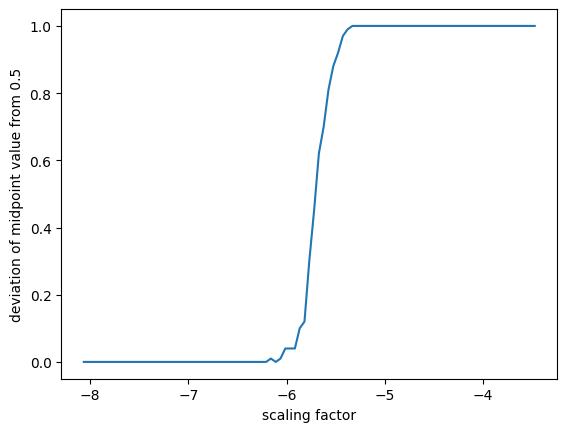

In [ ]:
hyperparameters['scaling_factor'] = optimal_scaling_factor()

print('scaling_factor:', hyperparameters['scaling_factor'])
print('range of success rate:', negotiation_success_rate_range(hyperparameters['scaling_factor']))
print('midpoint success rate:', negotiation_success_rate_equal_batch((MAX_INIT_MOTIV + MIN_INIT_MOTIV) // 2, nbr_team_members=0))
print('difference from desired midpoint value:', negotiation_success_rate_comparison(hyperparameters['scaling_factor']))

# check how well the optimization has performed
print()
x_grid = []
y_grid = []
x = hyperparameters['scaling_factor'] / 10.0
while x < hyperparameters['scaling_factor'] * 10.0:
    candidate_scaling_factor = x
    y = negotiation_success_rate_equal_batch((MAX_INIT_MOTIV + MIN_INIT_MOTIV) // 2, scaling_factor=candidate_scaling_factor, nbr_team_members=0)
    x_grid.append(np.log(x))
    y_grid.append(y)
    # print('success rate for scaling factor', x, np.log(x), ':', y)
    x *= 1.05

plt.plot(x_grid, y_grid)
plt.xlabel("scaling factor")
plt.ylabel("deviation of midpoint value from 0.5")
plt.show()


In [ ]:
# does scaling_factor depend on team size?

if DEBUG:
    old_nbr_team_members = hyperparameters['nbr_team_members']

    x_grid = []
    y_grid = []
    lny_grid = []

    hyperparameters['nbr_team_members'] = 0
    x_grid.append(0)
    y = optimal_scaling_factor()
    y_grid.append(y)
    lny_grid.append(math.log(y))

    for n in range(2,10):
        hyperparameters['nbr_team_members'] = n
        x_grid.append(n)
        y = optimal_scaling_factor()
        y_grid.append(y)
        lny_grid.append(math.log(y))

    print(x_grid)
    print(y_grid)

    plt.plot(x_grid, y_grid)
    plt.xlabel("team size")
    plt.ylabel("optimal scaling factor")
    plt.show()

    plt.plot(x_grid, lny_grid)
    plt.xlabel("team size")
    plt.ylabel("log optimal scaling factor")
    plt.show()

    hyperparameters['nbr_team_members'] = old_nbr_team_members


###Set the hyperparameter "scaling_factor"

In [ ]:
# Readiness, effort, and difficulty are in arbitrary units and therefore potentially incompatible, e.g. when we later
# multiply these variables together, the product may be bigger than the max values we are specifying here. The hyperparameter
# scaling_factor serves as a unit conversion factor to avoid this issue. We can set it manually or automatically.

if not DEBUG:
    hyperparameters['scaling_factor'] = optimal_scaling_factor()
else:
    # hyperparameters['scaling_factor'] = 0.085 # previously 1.0 - with 100 as max motiv, 0.085 gives 25% success rate in default negotiations
    # hyperparameters['scaling_factor'] = 0.2 # adapted for joint effort as the multiplication of all readiness and effort
    # hyperparameters['scaling_factor'] = 0.0038  # OK for 0 team members
    hyperparameters['scaling_factor'] = 0.03    # OK for 4 team members

print('scaling_factor:', hyperparameters['scaling_factor'])
print('range of success rate:', negotiation_success_rate_range())
print('midpoint success rate:', negotiation_success_rate_equal_batch((MAX_INIT_MOTIV + MIN_INIT_MOTIV) // 2))


scaling_factor: 0.003157135501642416
range of success rate: 1.0
midpoint success rate: 0.01


### Here initialize the system for a set of negotiations

In [ ]:
# prep a sample run

# if we want, we can initialize the team members biases

if hyperparameters['nbr_team_members'] == 4 and hyperparameters['nbr_parties'] == 2:
    bias_team_1 = np.array([0.5,0.4,0.3,0.2])
    bias_team_2 = np.array([0.2,0.3,0.4,0.5])
    initial_team_bias_1 = np.ones(shape=(hyperparameters['nbr_topics'],hyperparameters['nbr_team_members'])) * bias_team_1[np.newaxis,:]
    initial_team_bias_2 = np.ones(shape=(hyperparameters['nbr_topics'],hyperparameters['nbr_team_members'])) * bias_team_2[np.newaxis,:]
    #talk = Talks(uncertainty=1.0, initial_team_biases=[initial_team_bias_1,initial_team_bias_2])
    talk = Talks(uncertainty=5.0, initial_topics_difficulty=[5,6,4,3,5,4], initial_team_biases=[initial_team_bias_1,initial_team_bias_2])
else:
    talk = Talks([30,40],effort_strategy='fixed_unbiased')


### Visualize/print system initial conditions

In [ ]:
print('Peace cooperation Simulation. Nbr of parties involved : %d, nbr topics to discuss : %d'%(hyperparameters['nbr_parties'],hyperparameters['nbr_topics']))
print()
print(talk)


Peace cooperation Simulation. Nbr of parties involved : 2, nbr topics to discuss : 6

Parameters of the talks:
initial readiness=[83 31]
uncertainty=5.0
agenda strategy='increasing_difficulty'
effort strategy='fixed_unbiased'
probability of exogenous shock per round=0.0
number of teams=2
number of people on each team=4
initial topic difficulties=[5 6 4 3 5 4]
effort table=
[[0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]]
initial position platforms=
[[[13.098482  15.536126  12.821015  13.907201 ]
  [16.384735  18.415398  18.523876  19.726109 ]
  [19.244337  18.643978  14.513018  19.988556 ]
  [ 9.930646  10.810645  10.479998  12.776059 ]
  [17.381542  17.995079  17.877811  17.802555 ]
  [16.159203  14.944212  16.551622  13.754883 ]]

 [[14.855345  14.919831  14.168646  11.511196 ]
  [ 8.838702   6.298847   6.6440387  6.1222405]
  [ 4.2921257  5.3495965  4.0638237  4.9317865]
  [ 3.505959   5.458276   3.4267848  3.915903 ]
  [ 6.9504623  8.042358   5.610641 

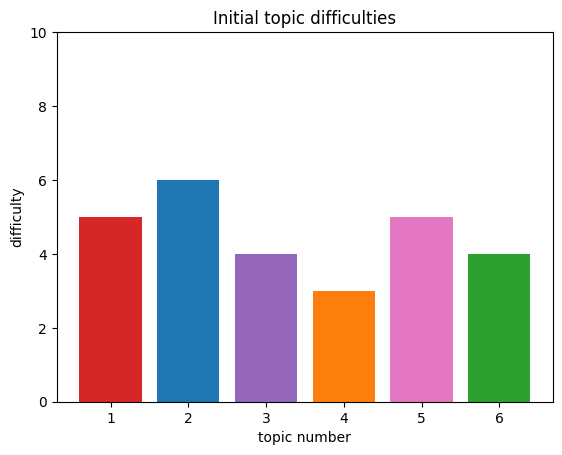

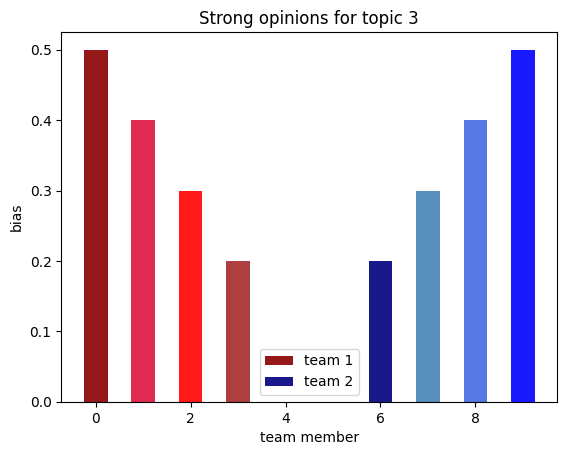

In [ ]:
plotICs(talk)


## Do a sample run

In [ ]:
if negotiate_legacy(talk):
    print("hooray!")
else:
    print("boo")
print(talk.nbr_rounds, 'rounds completed')

print()
print(talk)


boo
99 rounds completed

Parameters of the talks:
initial readiness=[83 31]
uncertainty=5.0
agenda strategy='increasing_difficulty'
effort strategy='fixed_unbiased'
probability of exogenous shock per round=0.0
number of teams=2
number of people on each team=4
initial topic difficulties=[5 6 4 3 5 4]
effort table=
[[0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]]
initial position platforms=
[[[13.098482  15.536126  12.821015  13.907201 ]
  [16.384735  18.415398  18.523876  19.726109 ]
  [19.244337  18.643978  14.513018  19.988556 ]
  [ 9.930646  10.810645  10.479998  12.776059 ]
  [17.381542  17.995079  17.877811  17.802555 ]
  [16.159203  14.944212  16.551622  13.754883 ]]

 [[14.855345  14.919831  14.168646  11.511196 ]
  [ 8.838702   6.298847   6.6440387  6.1222405]
  [ 4.2921257  5.3495965  4.0638237  4.9317865]
  [ 3.505959   5.458276   3.4267848  3.915903 ]
  [ 6.9504623  8.042358   5.610641  10.089845 ]
  [ 1.1932201  1.9539065  3.2469482  7.034341 ]]

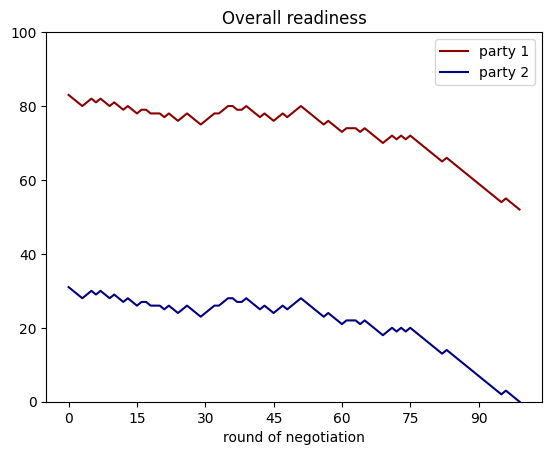

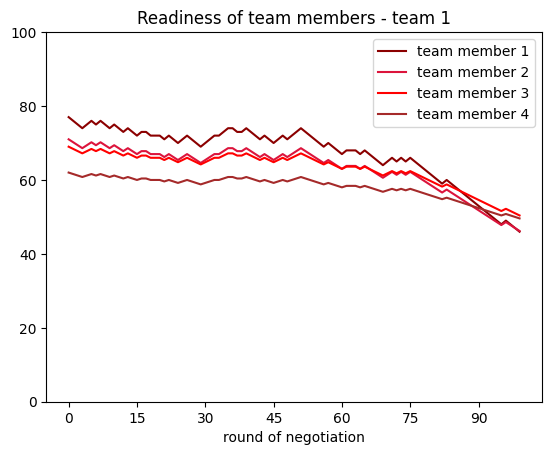

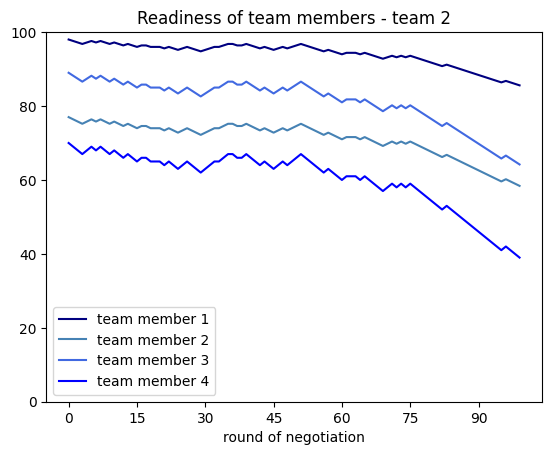

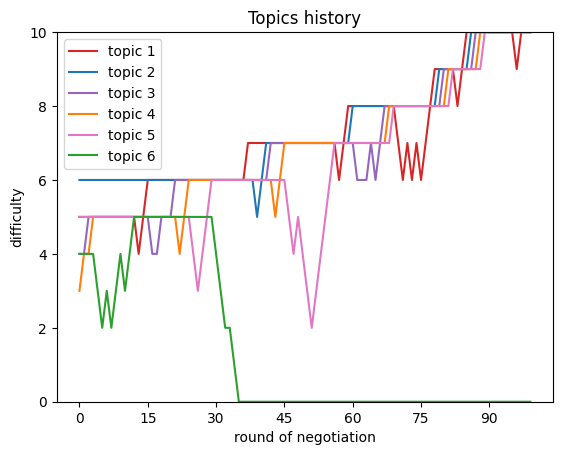

In [ ]:
plot_motiv_history(talk)
plot_topics_history(talk)


## Repeat the sample run using the platform version of the model

Parameters of the talks:
initial readiness=[83 31]
uncertainty=5.0
agenda strategy='increasing_difficulty'
effort strategy='fixed_unbiased'
probability of exogenous shock per round=0.0
number of teams=2
number of people on each team=4
initial topic difficulties=[5 6 4 3 5 4]
effort table=
[[0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]]
initial position platforms=
[[[13.098482  15.536126  12.821015  13.907201 ]
  [16.384735  18.415398  18.523876  19.726109 ]
  [19.244337  18.643978  14.513018  19.988556 ]
  [ 9.930646  10.810645  10.479998  12.776059 ]
  [17.381542  17.995079  17.877811  17.802555 ]
  [16.159203  14.944212  16.551622  13.754883 ]]

 [[14.855345  14.919831  14.168646  11.511196 ]
  [ 8.838702   6.298847   6.6440387  6.1222405]
  [ 4.2921257  5.3495965  4.0638237  4.9317865]
  [ 3.505959   5.458276   3.4267848  3.915903 ]
  [ 6.9504623  8.042358   5.610641  10.089845 ]
  [ 1.1932201  1.9539065  3.2469482  7.034341 ]]]
bias of people within p

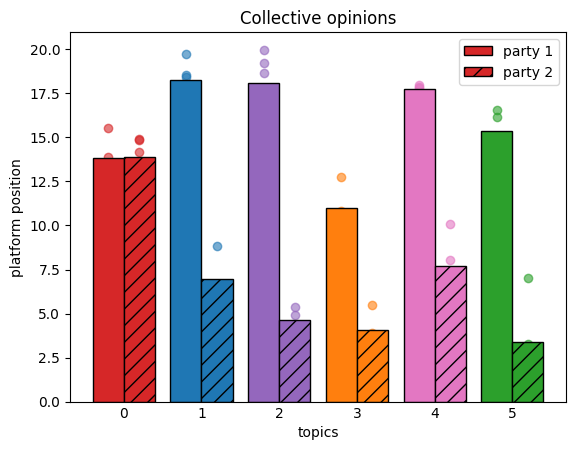

In [ ]:
# talk = Talks([30,40], effort_strategy='fixed_unbiased', disaggregation_rule='random_beta')

print(talk)
plotplatform(talk)


In [ ]:
if negotiate_platform(talk):
    print("hooray!")
else:
    print("boo")
print(talk.nbr_rounds, 'rounds completed')

print()
print(talk)


boo
56 rounds completed

Parameters of the talks:
initial readiness=[83 31]
uncertainty=5.0
agenda strategy='increasing_difficulty'
effort strategy='fixed_unbiased'
probability of exogenous shock per round=0.0
number of teams=2
number of people on each team=4
initial topic difficulties=[5 6 4 3 5 4]
effort table=
[[0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]]
initial position platforms=
[[[13.098482  15.536126  12.821015  13.907201 ]
  [16.384735  18.415398  18.523876  19.726109 ]
  [19.244337  18.643978  14.513018  19.988556 ]
  [ 9.930646  10.810645  10.479998  12.776059 ]
  [17.381542  17.995079  17.877811  17.802555 ]
  [16.159203  14.944212  16.551622  13.754883 ]]

 [[14.855345  14.919831  14.168646  11.511196 ]
  [ 8.838702   6.298847   6.6440387  6.1222405]
  [ 4.2921257  5.3495965  4.0638237  4.9317865]
  [ 3.505959   5.458276   3.4267848  3.915903 ]
  [ 6.9504623  8.042358   5.610641  10.089845 ]
  [ 1.1932201  1.9539065  3.2469482  7.034341 ]]

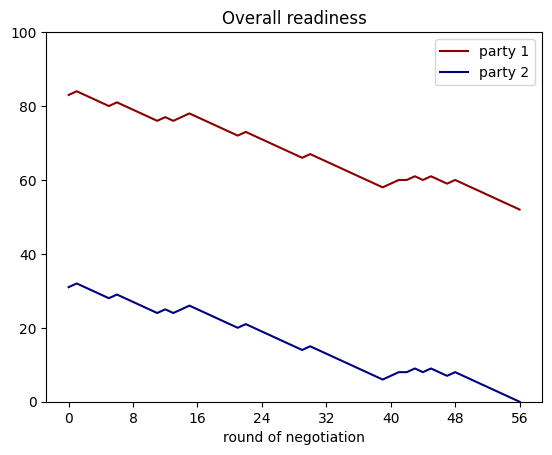

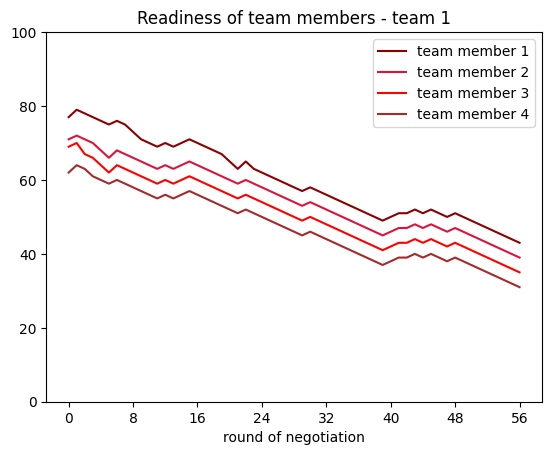

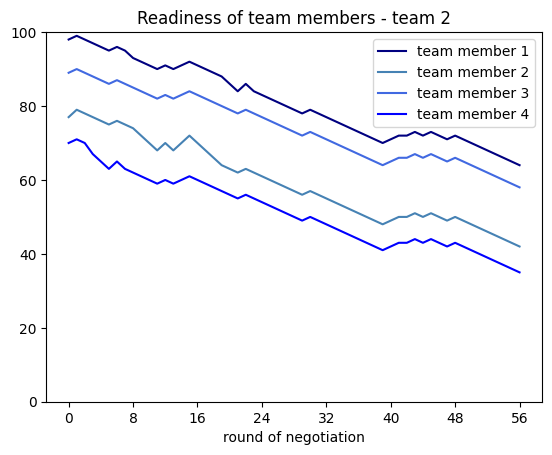

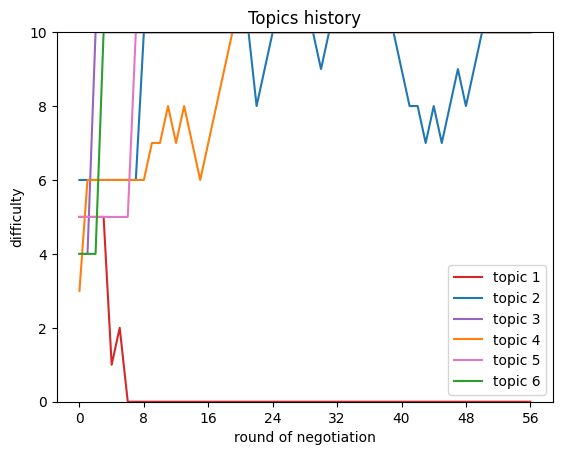

In [ ]:
plot_motiv_history(talk)
plot_topics_history(talk)


In [ ]:
plot_platform_history(talk, animate=True)


## Do a second sample run

In [ ]:
talk2 = Talks(uncertainty=4.0, shock_prob=0.1)

print('Peace cooperation Simulation. Nbr of parties involved : %d, nbr topics to discuss : %d'%(hyperparameters['nbr_parties'],hyperparameters['nbr_topics']))
print()
print(talk2)


Peace cooperation Simulation. Nbr of parties involved : 2, nbr topics to discuss : 6

Parameters of the talks:
initial readiness=[68 74]
uncertainty=4.0
agenda strategy='increasing_difficulty'
effort strategy='fixed_unbiased'
probability of exogenous shock per round=0.1
number of teams=2
number of people on each team=4
initial topic difficulties=[4 7 9 9 5 1]
effort table=
[[0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]]
initial position platforms=
[[[20.989906  20.998484  21.748009  15.772029 ]
  [20.962515  20.793055  20.882702  20.751583 ]
  [19.763893  19.490086  19.07539   19.929262 ]
  [ 9.151209   9.226253   9.046405   9.513306 ]
  [17.123272  17.650604  10.743618  16.619125 ]
  [16.337013  16.409752  16.829914  15.375501 ]]

 [[12.085512   6.116549   6.207108  10.238475 ]
  [ 5.0552683  8.394537   7.3983297  8.481665 ]
  [ 5.237188   4.136409   4.0146465  4.016891 ]
  [12.915629  12.166456  12.843479  11.924319 ]
  [ 4.184466   2.3640785  5.523738 

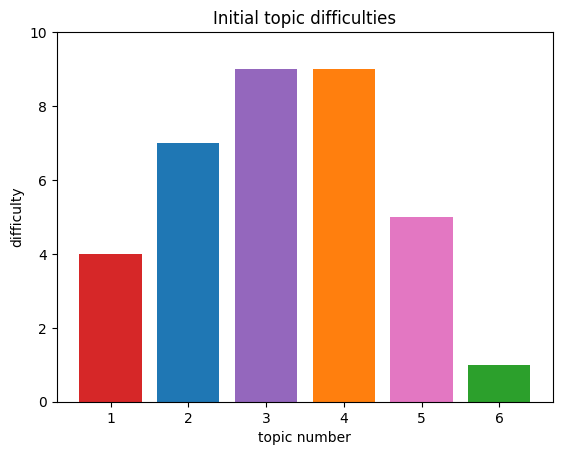

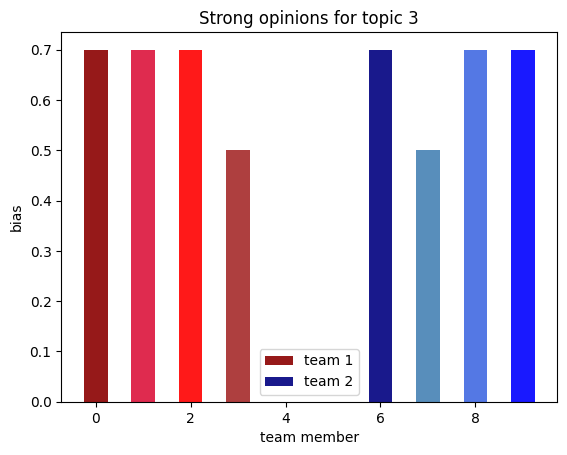

In [ ]:
plotICs(talk2)


In [ ]:
if negotiate_legacy(talk2):
    print("hooray!")
else:
    print("boo")
print(talk2.nbr_rounds, 'rounds completed')

print()
print(talk2)


boo
49 rounds completed

Parameters of the talks:
initial readiness=[68 74]
uncertainty=4.0
agenda strategy='increasing_difficulty'
effort strategy='fixed_unbiased'
probability of exogenous shock per round=0.1
number of teams=2
number of people on each team=4
initial topic difficulties=[4 7 9 9 5 1]
effort table=
[[0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]
 [0.65 0.65]]
initial position platforms=
[[[20.989906  20.998484  21.748009  15.772029 ]
  [20.962515  20.793055  20.882702  20.751583 ]
  [19.763893  19.490086  19.07539   19.929262 ]
  [ 9.151209   9.226253   9.046405   9.513306 ]
  [17.123272  17.650604  10.743618  16.619125 ]
  [16.337013  16.409752  16.829914  15.375501 ]]

 [[12.085512   6.116549   6.207108  10.238475 ]
  [ 5.0552683  8.394537   7.3983297  8.481665 ]
  [ 5.237188   4.136409   4.0146465  4.016891 ]
  [12.915629  12.166456  12.843479  11.924319 ]
  [ 4.184466   2.3640785  5.523738   2.0209312]
  [10.814085  10.941068  10.990184  10.187637 ]]

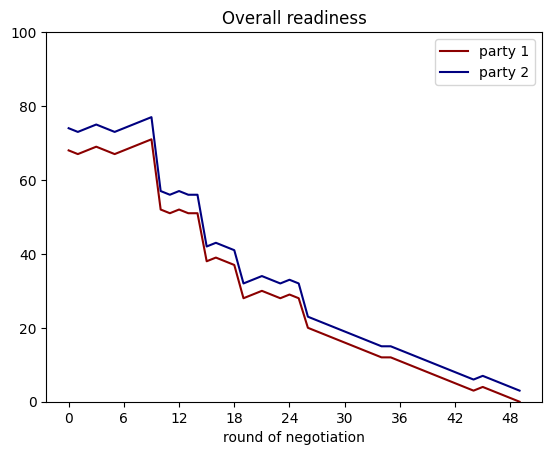

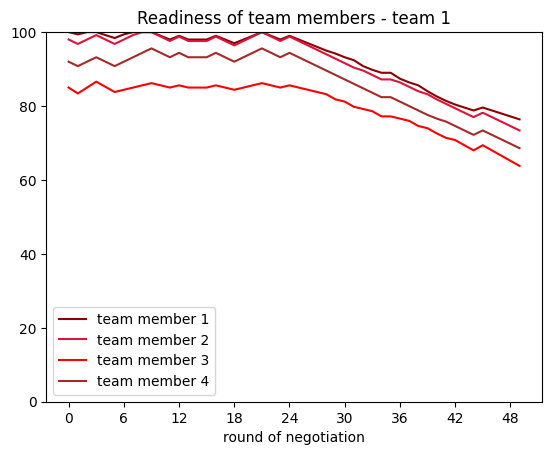

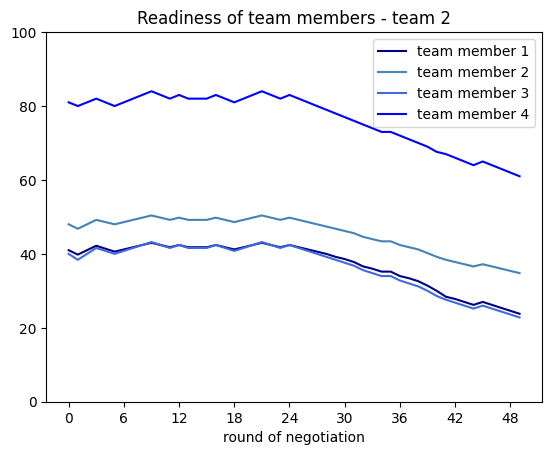

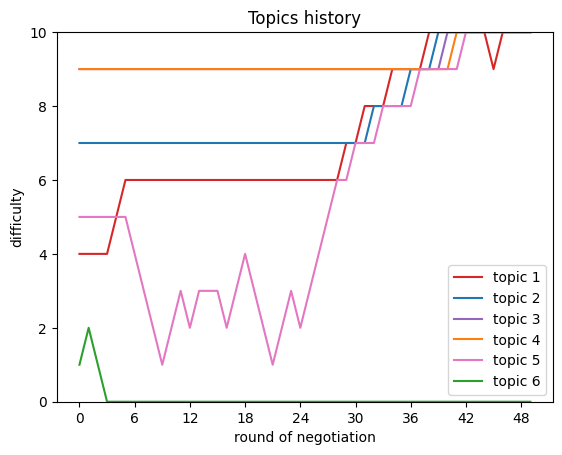

In [ ]:
plot_motiv_history(talk2)
plot_topics_history(talk2)


## Now begin to scan parameter space

In [ ]:
if DEBUG: raise AssertionError("won't scan parameter space when in debug mode")

# compute success rate as a function of initial condition, fixed uncertainty
uncertainty = 1


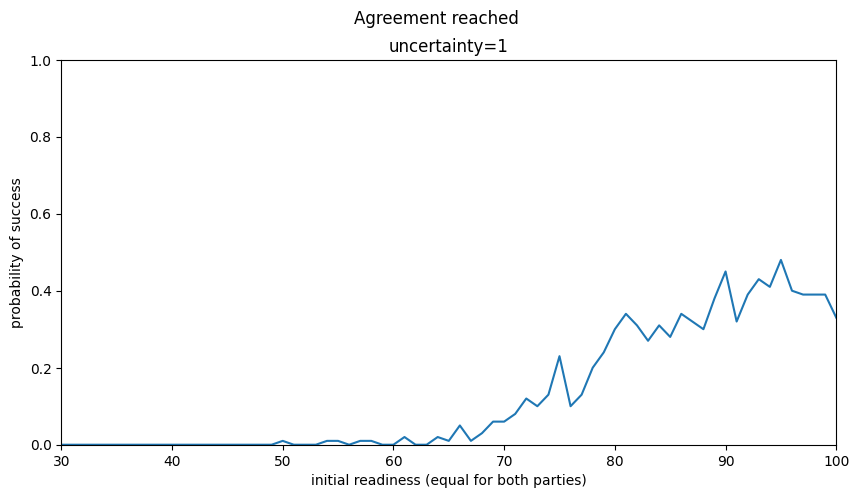

In [ ]:
# create a basic plot of the dependence of success on initial readiness

plot_negotiation_success_rate(uncertainty=uncertainty)


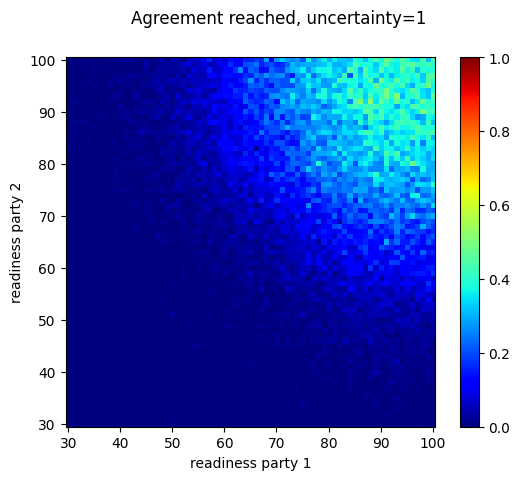

heatmap duration: 81094.91913099999 ms


In [ ]:
# produce heatmap

start_time = time.perf_counter()
plot_negotiation_success_heatmap(uncertainty=uncertainty)
end_time = time.perf_counter()
print('heatmap duration:', (end_time - start_time) * 1000, 'ms')


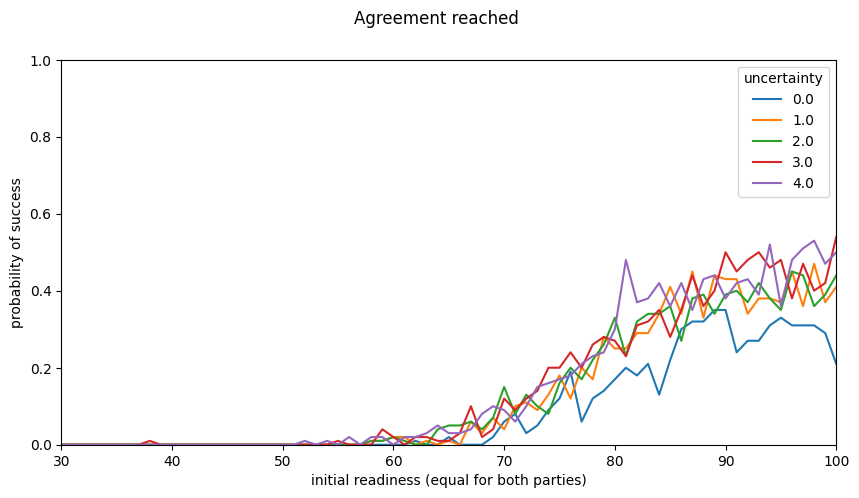

In [ ]:
## now scan success rate as a function of uncertainty
uncertainty_range = [0.0, 1.0, 2.0, 3.0, 4.0]

plot_negotiation_success_rate(uncertainty=uncertainty_range)


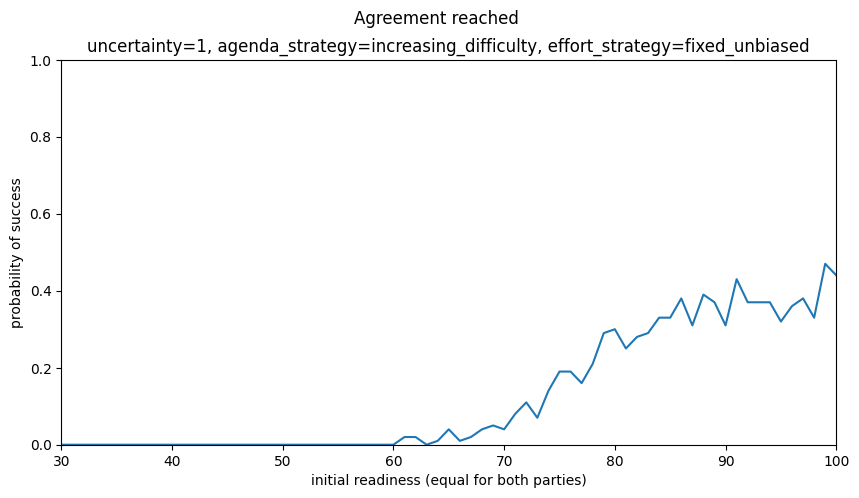

In [ ]:
# compute the success rate as a function of the initial readiness for various conditions

# agenda strategy = random
# compute success rate as a function of initial condition, fixed uncertainty
agenda_strategy='increasing_difficulty'
effort_strategy='fixed_unbiased'

plot_negotiation_success_rate(uncertainty=uncertainty, agenda_strategy=agenda_strategy, effort_strategy=effort_strategy)


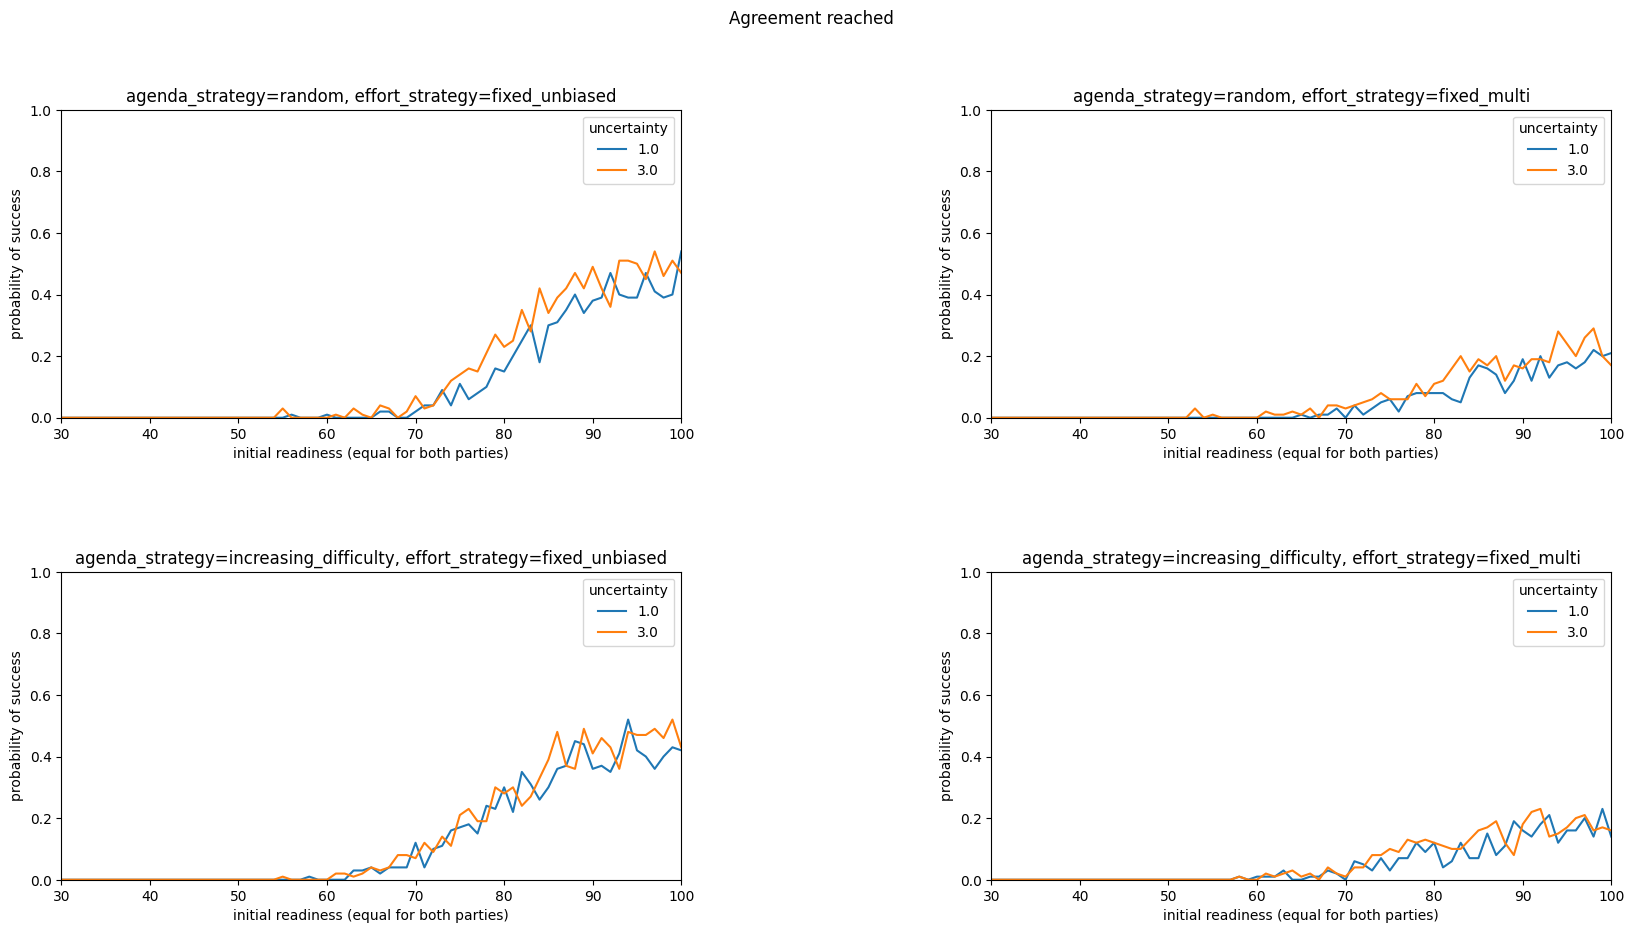

In [ ]:
# compute the success rate as a function of the initial readiness for various conditions

effort_options = ['fixed_unbiased','fixed_multi']
agenda_options = ['random', 'increasing_difficulty']
uncertainty_options = [1.0, 3.0]

plot_negotiation_success_rate(uncertainty=uncertainty_options, agenda_strategy=agenda_options, effort_strategy=effort_options)


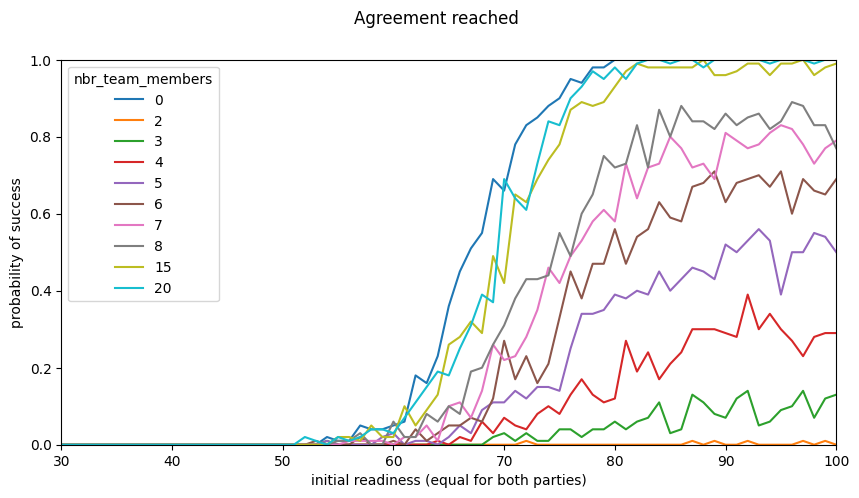

In [ ]:
# compute the success rate as a function of team size

team_size_options = [0, 2, 3, 4, 5, 6, 7, 8, 15, 20]

plot_negotiation_success_rate(nbr_team_members=team_size_options)


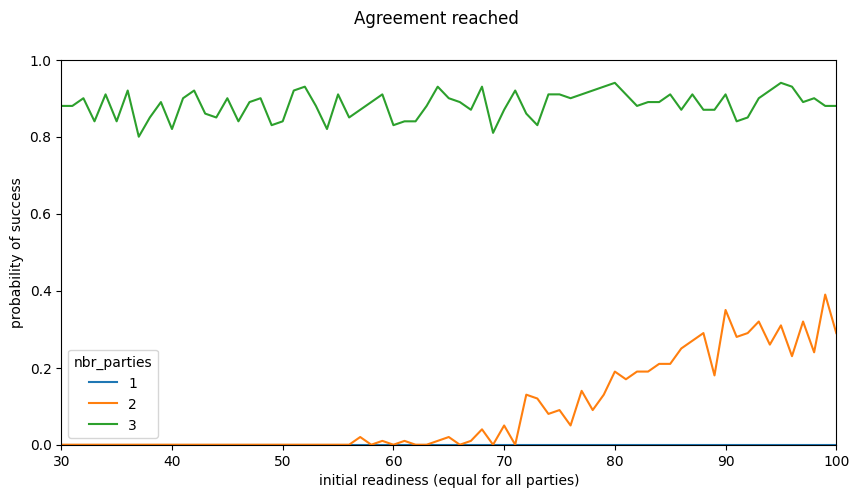

In [ ]:
# compute the success rate as a function of number of parties

nbr_parties_options = [1, 2, 3]

plot_negotiation_success_rate(nbr_parties=nbr_parties_options)


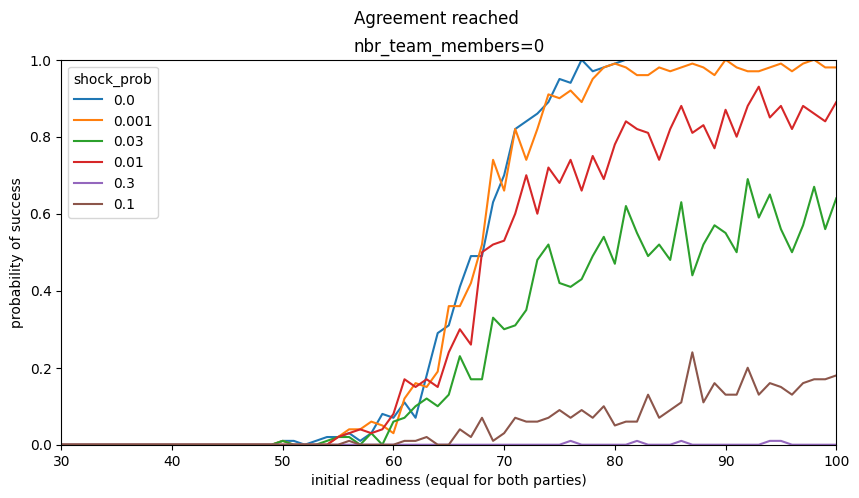

In [ ]:
# compute the success rate as a function of shock rate

shock_prob_options = [0.0, 1e-3, 3e-2, 1e-2, 0.3, 0.1]

plot_negotiation_success_rate(nbr_team_members=0, shock_prob=shock_prob_options)
